In [2]:
# Requirements : 
#   pip install -Iv ipywidgets==7.7.2
#   pip install git+https://github.com/manu-mannattil/nolitsa.git
#   pip install  nolds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 28 11:36:04 2016

@author: J. C. Vasquez-Correa
"""

import numpy as np
import math
from statsmodels.tsa.tsatools import lagmat
from sklearn.metrics.pairwise import euclidean_distances as dist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Dim_Corr(datas, Tao, m, graph=False): 
	"""
	Compute the correlation dimension of a time series with a time-lag Tao and an embedding dimension m
	datas--> time series to compute the correlation dimension
	Tao--> time lag computed using the first zero crossing of the auto-correlation function (see Tao func)   
	m--> embeding dimension of the time-series, computed using the false neighbors method (see fnn func)  
	graph (optional)--> plot the phase space (attractor) in 3D
	"""
	x=PhaseSpace(datas, m, Tao, graph)
	ED2=dist(x.T)
	posD=np.triu_indices_from(ED2, k=1)
	ED=ED2[posD]
	max_eps=np.max(ED)
	min_eps=np.min(ED[np.where(ED>0)])
	max_eps=np.exp(math.floor(np.log(max_eps)))
	n_div=int(math.floor(np.log(max_eps/min_eps)))
	n_eps=n_div+1
	eps_vec=range(n_eps)
	unos=np.ones([len(eps_vec)])*-1
	eps_vec1=max_eps*np.exp(unos*eps_vec-unos)
	Npairs=((len(x[1,:]))*((len(x[1,:])-1)))
	C_eps=np.zeros(n_eps)
 
	for i in eps_vec:
		eps=eps_vec1[i]
		N=np.where(((ED<eps) & (ED>0)))
		S=len(N[0])
		C_eps[i]=float(S)/Npairs

	omit_pts=1 
	k1=omit_pts
	k2=n_eps-omit_pts
	xd=np.log(eps_vec1)
	yd=np.log(C_eps)
	xp=xd[k1:k2]
	yp=yd[k1:k2]
	p = np.polyfit(xp, yp, 1)
	return p[0]


def PhaseSpace(data, m, Tao, graph=False):
  """
  Compute the phase space (attractor) a time series data with a time-lag Tao and an embedding dimension m
  data--> time series
  Tao--> time lag computed using the first zero crossing of the auto-correlation function (see Tao func)   
  m--> embeding dimension of the time-series, computed using the false neighbors method (see fnn func)  
  graph (optional)--> plot the phase space (attractor)
  """		
  ld=len(data)
  x = np.zeros([m, (ld-(m-1)*Tao)])
  for j in range(m):
      l1=(Tao*(j))
      l2=(Tao*(j)+len(x[1,:]))
      x[j,:]=data[l1:l2]
  if graph:
     fig = plt.figure()
     if m>2:
         ax = fig.add_subplot(111, projection='3d')
         ax.plot(x[0,:], x[1,:], x[2,:])
     else:
         ax = fig.add_subplot(111)
         ax.plot(x[0,:], x[1,:])         
  return x


def Tao(data):
    """
    Compute the time-lag of a time series data to build the phase space using the first zero crossing rate criterion
    data--> time series
    """    
    corr=np.correlate(data, data, mode="full")
    x = round(len(corr)/2)+1
    corr=corr[x:len(corr)]
    tau=0
    j=0
    while (corr[j]>0):
      j=j+1
      if(j==x): break
    tau=j
    return tau


def fnn(data, maxm):
    """
    Compute the embedding dimension of a time series data to build the phase space using the false neighbors criterion
    data--> time series
    maxm--> maximmum embeding dimension
    """    
    RT=15.0
    AT=2
    sigmay=np.std(data, ddof=1)
    nyr=len(data)
    m=maxm
    EM=lagmat(data, maxlag=m-1)
    EEM=np.asarray([EM[j,:] for j in range(m-1, EM.shape[0])])
    embedm=maxm
    for k in range(AT,EEM.shape[1]+1):
        fnn1=[]
        fnn2=[]
        Ma=EEM[:,range(k)]
        D=dist(Ma)
        for i in range(1,EEM.shape[0]-m-k):
            #print D.shape            
            #print(D[i,range(i-1)])
            d=D[i,:]
            pdnz=np.where(d>0)
            dnz=d[pdnz]
            Rm=np.min(dnz)
            l=np.where(d==Rm)
            l=l[0]
            l=l[len(l)-1]
            if l+m+k-1<nyr:
                fnn1.append(np.abs(data[i+m+k-1]-data[l+m+k-1])/Rm)
                fnn2.append(np.abs(data[i+m+k-1]-data[l+m+k-1])/sigmay)
        Ind1=np.where(np.asarray(fnn1)>RT)
        Ind2=np.where(np.asarray(fnn2)>AT)
        if len(Ind1[0])/float(len(fnn1))<0.1 and len(Ind2[0])/float(len(fnn2))<0.1:
            embedm=k
            break
    return embedm

def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 20, n_offsets = 0, plot = False):
    """Calculates the fractal dimension of a 3D numpy array.
    
    Args:
        array (np.ndarray): The array to calculate the fractal dimension of.
        max_box_size (int): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (int): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (int): number of offsets to search over to find the smallest set N(s) to
                       cover  all voxels>0.
        plot (bool): set to true to see the analytical plot of a calculation.
                            
        
    """
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)

In [4]:
def delay_embedding(data, emb_dim, lag=1):
  """
  Perform a time-delay embedding of a time series
  Args:
    data (array-like):
      the data that should be embedded
    emb_dim (int):
      the embedding dimension
  Kwargs:
    lag (int):
      the lag between elements in the embedded vectors
  Returns:
    emb_dim x m array:
      matrix of embedded vectors of the form
      [data[i], data[i+lag], data[i+2*lag], ... data[i+(emb_dim-1)*lag]]
      for i in 0 to m-1 (m = len(data)-(emb_dim-1)*lag)
  """
  data = np.asarray(data)
  min_len = (emb_dim - 1) * lag + 1
  if len(data) < min_len:
    msg = "cannot embed data of length {} with embedding dimension {} " \
        + "and lag {}, minimum required length is {}"
    raise ValueError(msg.format(len(data), emb_dim, lag, min_len))
  m = len(data) - min_len + 1
  indices = np.repeat([np.arange(emb_dim) * lag], m, axis=0)
  indices += np.arange(m).reshape((m, 1))
  return data[indices]

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 10 09:48:16 2020

@author: hkraemer
"""

import math
import numpy as np
import scipy
import random
from sklearn.neighbors import KDTree
from scipy.stats import binom, zscore

def pecuzal_embedding(s, taus = range(50), theiler = 1, sample_size = 1., K = 13, KNN = 3, L_threshold = 0.0, alpha = 0.05, p = 0.5, max_cycles = 10, econ = False):
    '''Performs an embedding of time series using the PECUZAL method

    Parameters
    ----------
    s : 'numpy.ndarray' (N, M)
        Input time series of length N as numpy array. This can be a multivariate set, where the M timeseries are stored in the columns.
    taus : `iterable`, optional
        Possible delay values in sampling time units (Default is `taus=range(50)`). For each of the `tau`'s in `taus` the continuity statistic 
        `avrg_eps_star` gets computed and further processed in order to find optimal delays for each embedding cycle.
    theiler : `int`, optional
        Theiler window for excluding serial correlated points from neighbourhood. In sampling time units, Default is `theiler = 1`.
    sample_size : `float`, optional
        Number of considered fiducial points as a fraction of input time series length, i.e. a float from interval (0,1.] (Default is 
        `sample_size = 1.0`, i.e., all points of the acutal trajectory get considered).
    K : `int`, optional
        The amount of nearest neighbors in the Delta-ball. Must be at least 8 (in order to guarantee a valid statistic) and the Default is
        `K = 13`. The continuity statistic `avrg_eps_star` is computed in each embedding cycle, taking the minimum result over all `k in K`.
    KNN : `int`, optional
        The number of nearest neighbors to be considered in the L-statistic, Default is `KNN = 3`.  
    L_threshold : `float`, optional
        The algorithm breaks, when this threshold is exceeded by `ΔL` in an embedding cycle (set as a positive number, i.e. an absolute value
        of `ΔL`).
    alpha : `float`, optional
        Significance level for obtaining the continuity statistic `avrg_eps_star` in each embedding cycle (Default is `alpha = 0.05`).
    p : `float`, optional
        Binominal p for obtaining the continuity statistic `avrg_eps_star` in each embedding cycle (Default is `p = 0.5`).
    max_cycles : `int`, optional
        The algorithm will stop after that many cycles no matter what. Default is `max_cycles = 10`.
    econ : `bool`, optional 
        Economy-mode for L-statistic computation. Instead of computing L-statistics for time horizons `2:Tw`, here we only compute them for
        `2:2:Tw`.
    
    Returns
    -------
    Y : 'numpy.ndarray' (N', m)
        The trajectory from the embedding of length `N' = N-sum(tau_vals)` of dimension `m` (embedding dimension)
    tau_vals : 'list' [`int`]
        The chosen delay values for each embedding cycle, `len(tau_vals) = m`.
    ts_vals : 'list' [`int`]
        The according time series number (index) chosen for each delay value in `tau_vals`, `len(ts_vals) = m`. For univariate embedding
        `ts_vals` is a vector of zeros of length `tau_vals`, because there is simply just one time series to choose from, i.e. index 0. 
    Ls : 'list'
        The :math:`\\Delta L`-statistic for each embedding cycle, including the very last encountered cycle, which will not enter the final
        trajectory `Y`. The total decrease of :math:`\\Delta L` is, thus, :math:`\\Delta L_t = np.sum(Ls[:-1])`.
    avrg_eps_stars : 'list' [`list`]
        The continuity statistics for each embedding cycle. Contains `avrg_eps_star` of each embedding cycle.
    
    See also
    --------
    uzal_cost
    uzal_cost_pecuzal
    continuity_statistic

    Notes
    -----
    The method works iteratively and gradually builds the final embedding vectors
    `Y`, as proposed in [kraemer2020]_ . Based on the continuity statistic `avrg_eps_star` [pecora2007]_ the algorithm picks an
    optimal delay value `tau_i` for each embedding cycle `i`. For achieving that, we take the inpute time series 
    `s`, denoted as the actual phase space trajectory `Y_actual` and compute the continuity statistic `avrg_eps_star`. 
    1. Each local maxima in `avrg_eps_star` is used for constructing a candidate embedding trajectory `Y_trial` with a delay 
    corresponding to that specific peak in `avrg_eps_star`. 
    2. We then compute the `L`-statistic [uzal2011]_ for `Y_trial` (`L-trial`) and `Y_actual` (`L_actual`) for increasing prediction 
    time horizons (free parameter in the `L`-statistic) and save the maximum difference `max(L-trial - L_actual)` as :math:`\\Delta L`
    (Note that this is a negative number, since the `L`-statistic decreases with better reconstructions).
    3. We pick the peak/`tau`-value, for which :math:`\\Delta L` is minimal (=maximum decrease of the overall `L`-value) and construct the actual 
    embedding trajectory `Y_actual` (steps 1.-3. correspond to an embedding cycle). 
    4. We repeat steps 1.-3. with `Y_actual` as input and stop the algorithm when :math:`\\Delta L` is > 0, i.e. when and additional embedding 
    component would not lead to a lower overall L-value. `Y_actual` -> `Y`.

    In case of multivariate embedding, i.e. when embedding a set of `M` time series, in each embedding cycle 
    the continuity statistic `avrg_eps_star` gets computed for all `M` time series available. The optimal delay value 
    `tau_i` in each embedding cycle `i` is chosen as the peak/`tau`-value for which :math:`\\Delta L` is minimal under all available peaks and under 
    all M `avrg_eps_star`'s. In the first embedding cycle there will be :math:`M^2` different `avrg_eps_star`'s to consider, since it is
    not clear a priori which time series of the input should consitute the first component of the embedding vector and form `Y_actual`.

    The range of considered delay values is determined in `taus` and for the nearest neighbor search we respect the Theiler window 
    `theiler`. The final embedding vector is stored in `Y` (`numpy.ndarray`). The chosen delay values for each embedding cycle are stored in 
    `tau_vals` (`list` of `int`) and the according time series numbers chosen for each delay value in `tau_vals` are stored in `ts_vals`. For 
    univariate embedding `ts_vals` is a vector of ones of length `len(tau_vals)`, because there is simply just one time series to choose 
    from. The function also returns the :math:`\\Delta Ls`-values `Ls` for each embedding cycle and the continuity statistic `avrg_eps_stars` as 
    `list` of `list`s.

    For distance computations the Euclidean norm is used.

    References
    ----------
    .. [pecora2007] Pecora et al., "A unified approach to attractor reconstruction", Chaos, vol. 17, 013110, 2007.  https://doi.org/10.1063/1.2430294
    .. [uzal2011] Uzal et al., "Optimal reconstruction of dynamical systems: A noise amplification approach", Physical Review E,
        vol. 84, 016223, 2011. https://doi.org/10.1103/PhysRevE.84.016223
    '''    
    if np.ndim(s)>1:
        assert (np.size(s,0) > np.size(s,1)), "You must provide a numpy array storing the time series in its columns."
        D = np.size(s,1)
    else:
        D = 1
    assert (K >= 8) and (type(K) is int) and (K < len(s)) , "You must provide a delta-neighborhood size consisting of at least 8 neighbors."
    assert (KNN >= 1) and (type(KNN) is int), "You must provide a valid integer number of considered nearest neighbours for the computation of the L-statistic." 
    assert (sample_size > 0) and (sample_size <= 1), "sample_size must be in (0 1]"
    assert (theiler >= 0) and (type(theiler) is int) and (theiler < len(s)), "Theiler window must be a positive integer smaller than the time series length."
    assert (alpha >= 0) and (alpha < 1), "Significance level alpha must be in (0 1)"
    assert (p >= 0) and (p < 1), "Binomial p parameter must be in (0 1)"
    assert (L_threshold >= 0), "L_threshold must be given as an absolute value, i.e. a positive number."
    assert (type(econ) is bool), "econ parameter must be a Boolean. Set to True or False (default)" 
    norm = 'euclidean' 
    threshold = -L_threshold

    s_orig = s
    s = zscore(s,ddof=1) # especially important for comparative L-statistics
    # define actual phase space trajectory
    Y_act = []

    # set a flag, in order to tell the while loop when to stop. Each loop
    # stands for encountering a new embedding dimension
    flag, counter = True, 0

    # preallocate output variables
    tau_vals = [0]
    ts_vals = []
    Ls = []
    eps = np.empty(shape=(len(taus), max_cycles))

    # loop over increasing embedding dimensions until some break criterion will
    # tell the loop to stop/break
    print('PECUZAL embeds your time series: Executing embedding cycle no.: 1 of ' + str(max_cycles))

    while flag:
        print('PECUZAL embeds your time series: Executing embedding cycle no.:{}'.format(counter+2))
        Y_act, tau_vals, ts_vals, Ls, eps = pecuzal_multivariate_embedding_cycle(
                Y_act, flag, s, taus, theiler, counter, eps, tau_vals, norm,
                Ls, ts_vals, sample_size, K, alpha, p, KNN, econ)

        flag = pecuzal_break_criterion(Ls, counter, max_cycles, threshold)
        counter += 1


    # construct final reconstruction vector
    if D > 1:
        Y_final = s_orig[:,ts_vals[0]]
        for i in range(len(tau_vals[:-2])):
            Y_final = hcat_lagged_values(Y_final,s_orig[:,ts_vals[i+1]],tau_vals[i+1])
    else:
        Y_final = s_orig
        for i in range(len(tau_vals[:-2])):
            Y_final = hcat_lagged_values(Y_final,s_orig,tau_vals[i+1])       
    
    return Y_final, tau_vals[:-1], ts_vals[:-1], Ls[:-1], eps[:,:counter]

def pecuzal_multivariate_embedding_cycle(Y_act, flag, Ys, taus, theiler, counter, eps, tau_vals, norm,
        Ls, ts_vals, sample_size, K, alpha, p, KNN, econ):
    '''Perform one embedding cycle on `Y_act` with a multivariate set Ys
    '''
    if np.ndim(Ys)>1:
        M = np.size(Ys,1)
    else:
        M = 1

    # in the 1st cycle we have to check all (size(Y,2)^2 combinations and pick
    # the tau according to minimial xi = (peak height * resulting L-statistic)
    if counter == 0:
        Y_act, tau_vals, ts_vals, Ls, eps = first_embedding_cycle_pecuzal(Ys, M, taus, theiler, sample_size, K,
                                norm, alpha, p, KNN, tau_vals, ts_vals, Ls, eps, econ)
    # in all other cycles we just have to check (size(Y,2)) combinations and pick
    # the tau according to minimal resulting L-statistic
    else:
        Y_act, tau_vals, ts_vals, Ls, eps = embedding_cycle_pecuzal(Y_act, Ys, counter, M, taus, theiler, sample_size,
                            K, norm, alpha, p, KNN, tau_vals, ts_vals, Ls, eps, econ)

    return Y_act, tau_vals, ts_vals, Ls, eps

def first_embedding_cycle_pecuzal(Ys, M, taus, theiler, sample_size, K,
                        norm, alpha, p, KNN, tau_vals, ts_vals, Ls, eps, econ):
    '''Perform the first embedding cycle of the multivariate embedding.
    '''
    counter = 0

    if M > 1:
        L_min = np.zeros(M)
        L_min_idx = np.zeros(M, dtype=int)
        idx = np.zeros(M, dtype=int)
        estar = np.zeros(shape=(len(taus), M*M))
        for ts in range(M):
            estar[:,(M*ts):(M*(ts+1))] = continuity_statistic(Ys, [0], [ts], delays = taus, sample_size = sample_size, 
                                                K = K, theiler = theiler, norm = norm, alpha = alpha, p = p)
            
            L_min[ts], L_min_idx[ts], idx[ts] = choose_right_embedding_params_first(
                                            estar[:,(M*ts):(M*(ts+1))], Ys[:,ts],
                                            Ys, taus, KNN, theiler, sample_size,
                                            norm, econ)

        min_idx = np.argmin(L_min)
        if np.ndim(min_idx) > 0:
            min_idx = min_idx[0]
        L_mini = L_min[min_idx]
        # update tau_vals, ts_vals, Ls
        tau_vals.append(taus[L_min_idx[min_idx]])
        ts_vals.append(min_idx) # time series to start with
        ts_vals.append(idx[min_idx]) # result of 1st embedding cycle
        Ls.append(L_mini) 
        eps[:,counter] = estar[:,(M*ts_vals[0])+ts_vals[1]]
        # create phase space vector for this embedding cycle
        Y_act = hcat_lagged_values(Ys[:,ts_vals[0]],
                                    Ys[:,ts_vals[1]],tau_vals[1])
    else:
        estar = continuity_statistic(Ys, [0], [0], delays = taus, sample_size = sample_size, 
                                        K = K, theiler = theiler, norm = norm, alpha = alpha, p = p)
        L_min, L_min_idx, idx = choose_right_embedding_params_first(
                                        estar, Ys, Ys, taus, KNN, theiler, sample_size, norm, econ)
        # update tau_vals, ts_vals, Ls
        tau_vals.append(taus[L_min_idx])
        ts_vals.append(0) # time series to start with
        ts_vals.append(idx) # result of 1st embedding cycle
        Ls.append(L_min)
        eps[:,counter] = estar
        # create phase space vector for this embedding cycle
        Y_act = hcat_lagged_values(Ys,Ys,tau_vals[1])   

    return Y_act, tau_vals, ts_vals, Ls, eps

def embedding_cycle_pecuzal(Y_act, Ys, counter, M, taus, theiler, sample_size,
                    K, norm, alpha, p, KNN, tau_vals, ts_vals, Ls, eps, econ):
    """Perform an embedding cycle of the multivariate embedding, but the first one.
    """
    
    estar = continuity_statistic(Ys, tau_vals, ts_vals, delays = taus, sample_size = sample_size, 
                                    K = K, theiler = theiler, norm = norm, alpha = alpha, p = p)
    # update tau_vals, ts_vals, Ls, eps
    L_min, L_min_idx, idx = choose_right_embedding_params(estar, Y_act, Ys, taus, KNN, theiler, sample_size, norm, econ)

    tau_vals.append(taus[L_min_idx])
    ts_vals.append(idx)
    Ls.append(L_min)
    if np.ndim(Ys)>1:
        eps[:,counter] = estar[:,ts_vals[-1]]
        # create phase space vector for this embedding cycle
        Y_act = hcat_lagged_values(Y_act, Ys[:, ts_vals[-1]], tau_vals[-1])
    else:
        eps[:,counter] = estar
        # create phase space vector for this embedding cycle
        Y_act = hcat_lagged_values(Y_act, Ys, tau_vals[-1])  

    return Y_act, tau_vals, ts_vals, Ls, eps

def choose_right_embedding_params_first(estar, Y_act, s, taus, KNN, theiler, sample_size, norm, econ):
    '''Choose the right embedding parameters of the estar-statistic in the first
    embedding cycle. Return the `L`-decrease-value, the corresponding index value of
    the chosen peak `tau_idx` and the number of the chosen time series `ts_idx` to start with.
    
    Parameters
    ----------
    estar : `numpy.ndarray` (len(taus), M)
        The M continuity statistic(s) for delays `taus`.
    Y_act : `numpy.ndarray`
        The actual phase space trajectory.
    s : numpy.ndarray` (N, M)
        The `M` time series of length `N`.
    taus : `iterable`
        Possible delay values in sampling time units.
    KNN : `int`
        The number of nearest neighbors to be considered in the L-statistic.
    theiler : `int`
        Theiler window for excluding serial correlated points from neighbourhood, in sampling time units.
    sample_size : `float`
        Number of considered fiducial points as a fraction of input time series length, i.e. a float from interval (0,1.].
    norm : `str`
        The norm used for distance computations.
    econ : `bool`
        Economy-mode for L-statistic computation. Instead of computing L-statistics for time horizons `2:Tw`, here we only compute them for
        `2:2:Tw`.

    Returns
    -------
    L : `float`
        `L`-value of chosen peak in `estar`
    tau_idx : `int`
        The corresponding index value of the chosen peak 
    ts_idx : `int`
        The number of the chosen time series to start with

    See also
    --------
    continuity_statistic
    '''
    D = np.ndim(s)
    if D > 1:
        M = np.size(s,1)
        L_min_ = np.zeros(M)
        tau_idx = np.zeros(M, dtype=int)
        for ts in range(M):
            # zero-padding of estar in order to also cover tau=0 (important for the multivariate case)
            # get the L-statistic for each peak in estar and take the one according to L_min
            L_trials_, max_idx_ = local_L_statistics(np.insert(estar[:,ts],0,0), Y_act, s[:,ts],
                                            taus, KNN, theiler, sample_size, norm, econ)

            min_idx_ = np.argmin(L_trials_)
            if np.ndim(min_idx_)>0:
                min_idx_ = min_idx_[0]
            L_min_[ts] = L_trials_[min_idx_]
            tau_idx[ts] = max_idx_[min_idx_]-1

        idx = np.argmin(L_min_)
        if np.ndim(idx)>0:
            idx = idx[0]

        return L_min_[idx], tau_idx[idx], idx
    else:
        L_trials_, max_idx_ = local_L_statistics(np.insert(estar,0,0), Y_act, s,
                                    taus, KNN, theiler, sample_size, norm, econ)
        min_idx_ = np.argmin(L_trials_)

        if np.ndim(min_idx_)>0:
            min_idx_ = min_idx_[0]
        L_min_ = L_trials_[min_idx_]
        tau_idx = max_idx_[min_idx_]-1

        return L_min_, tau_idx, int(0)

def choose_right_embedding_params(estar, Y_act, s, taus, KNN, theiler, sample_size, norm, econ):
    '''Choose the right embedding parameters of the estar-statistic in any embedding cycle, but the
    first one, on the basis of minimal `L`, i.e. maximal `L_decrease`.
    
    Parameters
    ----------
    estar : `numpy.ndarray` (len(taus), M)
        The M continuity statistic(s) for delays `taus`.
    Y_act : `numpy.ndarray`
        The actual phase space trajectory.
    s : numpy.ndarray` (N, M)
        The `M` time series of length `N`.
    taus : `iterable`
        Possible delay values in sampling time units.
    KNN : `int`
        The number of nearest neighbors to be considered in the L-statistic.
    theiler : `int`
        Theiler window for excluding serial correlated points from neighbourhood, in sampling time units.
    sample_size : `float`
        Number of considered fiducial points as a fraction of input time series length, i.e. a float from interval (0,1.].
    norm : `str`
        The norm used for distance computations.
    econ : `bool`  
        Economy-mode for L-statistic computation. Instead of computing L-statistics for time horizons `2:Tw`, here we only compute them for
        `2:2:Tw`.

    Returns
    -------
    L : `float`
        `L`-value of chosen peak in `estar`
    tau_idx : `int`
        The corresponding index value of the chosen peak 
    ts_idx : `int`
        The number of the chosen time series to start with

    See also
    --------
    continuity_statistic
    '''
    D = np.ndim(s)
    if D > 1:
        M = np.size(s,1)
        L_min_ = np.zeros(M)
        tau_idx = np.zeros(M, dtype=int)
        for ts in range(M):
            # zero-padding of estar in order to also cover tau=0 (important for the multivariate case)
            # get the L-statistic for each peak in estar and take the one according to L_min
            L_trials_, max_idx_ = local_L_statistics(np.insert(estar[:,ts],0,0), Y_act, s[:,ts],
                                            taus, KNN, theiler, sample_size, norm, econ)
            min_idx_ = np.argmin(L_trials_)
            if np.ndim(min_idx_)>0:
                min_idx_ = min_idx_[0]
            L_min_[ts] = L_trials_[min_idx_]
            tau_idx[ts] = max_idx_[min_idx_]-1

        idx = np.argmin(L_min_)
        if np.ndim(idx)>0:
            idx = idx[0]

        return L_min_[idx], tau_idx[idx], idx
    else:
        L_trials_, max_idx_ = local_L_statistics(np.insert(estar,0,0), Y_act, s,
                                    taus, KNN, theiler, sample_size, norm, econ)

        min_idx_ = np.argmin(L_trials_)
        if np.ndim(min_idx_)>0:
            min_idx_ = min_idx_[0]
        L_min_ = L_trials_[min_idx_]
        tau_idx = max_idx_[min_idx_]-1

        return L_min_, tau_idx, int(0)

def local_L_statistics(estar, Y_act, s, taus, KNN, theiler, sample_size, norm, econ):
    '''Return the maximum decrease of the L-statistic `L_decrease` and corresponding
    delay-indices `max_idx` for all local maxima in `estar`.
    '''
    _, max_idx = get_maxima(estar) # determine local maxima in estar
    if np.ndim(max_idx)>0:
        L_decrease = np.zeros(len(max_idx), dtype=float)

    for (i,tau_idx) in enumerate(max_idx):
        # create candidate phase space vector for this peak/τ-value
        Y_trial = hcat_lagged_values(Y_act,s,taus[int(tau_idx)-1])
        # compute L-statistic for Y_act and Y_trial and get the maximum decrease
        if np.ndim(max_idx)>0:
            L_decrease[i] = uzal_cost_pecuzal(Y_act, Y_trial, taus[-1], K = KNN, theiler = theiler, norm = norm, econ = econ)
            
        else:
            L_decrease = uzal_cost_pecuzal(Y_act, Y_trial, taus[-1], K = KNN, theiler = theiler, norm = norm, econ = econ)
                   
    return L_decrease, max_idx

def get_maxima(s):
    '''Return the maxima of the given time series `s` and its indices
    '''
    maximas = []
    maximas_idx = []
    N = len(s)
    flag = False
    first_point = 0
    for i in range(N-1):
        if (s[i-1] < s[i]) and (s[i+1] < s[i]):
            flag = False
            maximas.append(s[i])
            maximas_idx.append(i)
        
        # handling constant values
        if flag:
            if s[i+1] < s[first_point]:
                flag = False
                maximas.append(s[first_point])
                maximas_idx.append(first_point)
                
            elif s[i+1] > s[first_point]:
                flag = False
            
        if (s[i-1] < s[i]) and (s[i+1] == s[i]):
            flag = True
            first_point = i
        
    # make sure there is no empty vector returned
    if np.size(maximas) == 0:
        maximas_idx = np.argmax(s)
        if np.ndim(maximas_idx)>0:
            maximas_idx = maximas_idx[0]
        maximas = s[maximas_idx]
    
    return maximas, maximas_idx

def hcat_lagged_values(Y, s, tau):
    '''Add the `tau` lagged values of the timeseries `s` as additional component to `Y`
    (`np.ndarray`), in order to form a higher embedded dataset `Z`. 
    The dimensionality of `Z` is thus equal to that of `Y` + 1.
    '''
    assert tau >= 0
    N = len(Y)
    MM = len(s)
    try:
        D = np.size(Y,1)
    except IndexError:
        D = 1
    assert N <= MM
    MMM = MM - tau
    M = np.min([N,MMM])

    data = np.empty(shape=(M,D+1))

    if D > 1:
        data[:,:-1] = Y[:M,:]
    else:
        data[:,0] = Y[:M]

    for i in range(M):
        data[i,-1] = s[i+tau]
         
    return data

def pecuzal_break_criterion(Ls, counter, max_num_of_cycles, threshold):
    '''Checks whether some break criteria are fulfilled
    '''
    flag = True
    if counter == 0 and Ls[-1]>threshold:
        print("Algorithm stopped due to increasing L-values in the first embedding cycle.. Valid embedding NOT achieved.")
        flag = False
        
    if counter > 0 and Ls[-1]>threshold:
        print("Algorithm stopped due to increasing L-values. VALID embedding achieved.")
        flag = False

    if max_num_of_cycles-1 == counter:
        print("Algorithm stopped due to hitting max cycle number. Valid embedding NOT achieved.")
        flag = False

    return flag

def continuity_statistic(s, taus, js, delays = range(50), sample_size = 1.0, K = 13, theiler = 1, norm = 'euclidean', alpha = 0.05, p = 0.5):
    '''Compute the continuity statistic for a trajectory defined by `s`, `taus` and `js` and all time series stored in `s`.

    Parameters
    ----------
    s : `numpy.ndarray` (N, M)
        Input time series of length `N`. This can be a multivariate set, consisting of `M` time series, which are stored in the columns.
    taus : `list` or `numpy.ndarray`
        Denotes what delay times will be used for constructing the trajectory for which the continuity statistic to all time series in
        `s` will be computed.
    js : `list` or `numpy.ndarray`
        Denotes which of the timeseries contained in `s` will be used for constructing the trajectory using the delay values stored in
        `taus`. `js` can contain duplicate indices.
    delays : `iterable`, optional
        Possible delay values in sampling time units (Default is `delays = range(50)`). The continuity statistic `avrg_eps_star` is a 
        function of these delay values.
    sample_size : `float`, optional
        Number of considered fiducial points as a fraction of input time series length, i.e. a float :math:`\\in (0,1.]` (Default is 
        `sample_size = 1.0`, i.e., all points of the acutal trajectory get considered).
    K : `int`, optional
        The amount of nearest neighbors in the :math:`\\delta`-ball. Must be at least 8 (in order to guarantee a valid statistic) and the Default is
        `K = 13`. The continuity statistic `avrg_eps_star` is computed by taking the minimum result over all :math:`k \\in K`.
    theiler : `int`, optional
        Theiler window for excluding serial correlated points from neighbourhood. In sampling time units, Default is `theiler = 1`.
    norm : `str`, optional
        The norm used for distance computations. Must be either `'euclidean'` (Default) or `'chebyshev'`
    alpha : `float`, optional
        Significance level for obtaining the continuity statistic `avrg_eps_star` in each embedding cycle (Default is `alpha = 0.05`).
    p : `float`, optional
        Binominal p for obtaining the continuity statistic `avrg_eps_star` in each embedding cycle (Default is `p = 0.5`).

    Returns
    -------
    avrg_eps_star : `numpy.ndarray` (len(delays), M)
        The continuity statistic `avrg_eps_star` for each of the `M` time series in `s` for the given trajectory
        specified by the general embedding parameters `taus` and `js` and for all delay values specified in `delays`.

    See also
    --------
    pecuzal_embedding

    Notes
    -----
    The full algorithm is too large to discuss here and written in detail in Ref. [pecora2007]_ and in summary in Ref. [kraemer2020]_ .
    '''
    if np.ndim(s)>1:
        assert (np.size(s,0) > np.size(s,1)), "You must provide a numpy array storing the time series in its columns."
        D = np.size(s,1)
        all_eps_star = np.empty(shape=(len(delays), D))
    else:
        D = 1
    assert (K >= 8) and (type(K) is int) and (K < len(s)) , "You must provide a delta-neighborhood size consisting of at least 8 neighbors."
    assert (sample_size > 0) and (sample_size <= 1), "sample_size must be in (0 1]"
    assert (theiler >= 0) and (type(theiler) is int) and (theiler < len(s)), "Theiler window must be a positive integer smaller than the time series length."
    assert (alpha >= 0) and (alpha < 1), "Significance level alpha must be in (0 1)"
    assert (p >= 0) and (p < 1), "Binomial p parameter must be in (0 1)"
    assert (type(norm) is str) and (norm == 'euclidean' or norm == 'chebyshev')

    vspace = genembed(s, taus, js)
    vtree = KDTree(vspace[:-np.amax(delays)], metric = norm)

    # pick fiducial points
    if sample_size == 1:
        N = len(vspace)-delays[-1]
        ns = np.arange(N)
    else:
        N = int(np.floor(sample_size*(len(vspace)-delays[-1])))
        ns = random.sample(list(np.arange(len(vspace)-delays[-1])),N) # the fiducial point indices

    vs = vspace[ns]
    allNNidxs, _ = all_neighbors(vtree, vs, ns, K, theiler, len(vspace[:-np.amax(delays)]))

    # Loop over potential timeseries to use in new embedding
    for i in range(D):
        if D == 1:
            x = (s-np.mean(s))/np.std(s,ddof=1) # so that different timeseries can be compared
            all_eps_star = continuity_per_timeseries(x, ns, allNNidxs, delays, K, alpha, p)
        else:
            x = s[:,i]
            x = (x-np.mean(x))/np.std(x,ddof=1) # so that different timeseries can be compared
            all_eps_star[:,i] = continuity_per_timeseries(x, ns, allNNidxs, delays, K, alpha, p)

    return all_eps_star

def genembed(s, taus, js):
    '''Perform an embedding with delays `taus` and time series stored in `s`, specified by their indices `js`

    Parameters
    ----------
    s : `numpy.ndarray` (N, M)
        Input time series of length `N`. This can be a multivariate set, consisting of `M`time series, which are stored in the columns.
    taus : `list` or `numpy.ndarray`
        Denotes what delay times will be used for constructing the trajectory for which the continuity statistic to all time series in
        `s` will be computed.
    js : `list` or `numpy.ndarray`
        Denotes which of the timeseries contained in `s` will be used for constructing the trajectory using the delay values stored in
        `taus`. `js` can contain duplicate indices.

    Returns
    -------
    Y : `numpy.ndarray` (N', d)
        The trajectory from the embedding of length `N' = N-sum(taus)` of dimension `d = len(taus)`.

    Notes
    -----
    The generalized embedding works as follows:
    `taus, js` are `list`'s (or `numpy.ndarray`'s) of length `d`, which also coincides with the embedding dimension. For example, imagine 
    input trajectory :math:`s = [x, y, z]` where :math:`x, y, z` are timeseries (the columns of `s`).
    If `js = (0, 2, 1)` and `taus = (0, 2, 7)` the created delay vector at each step `t` will be

    .. math:: (x(t), z(t+2), y(t+7))

    '''
    assert np.amax(js) <= np.ndim(s)
    if np.ndim(s) == 1:
        assert js[0] == 0 
    N = len(s) - np.amax(taus)
    data = np.empty(shape=(N,len(taus)))
    for (i, tau) in enumerate(taus):
        if np.ndim(s) == 1:
            data[:,i] = s[tau:(N+tau)]
        else:
            data[:,i] = s[tau:(N+tau), js[i]]
    return data

def get_binomial_table(p = 0.5, alpha = 0.05, trial_range = 8):
    '''Compute the numbers of points from the :math:`\\delta`-neighborhood, which need to fall outside the :math:`\\varepsilon`-neighborhood, in order to reject 
    the Null Hypothesis at a significance level :math:`\\alpha`.

    Parameters
    ----------
    p : `float`, optional
        Binominal p (Default is `p = 0.5`).
    alpha : `float`, optional
        Significance level in order to be able to reject the Null on the basis of the binomial distribution (Default is `alpha = 0.05`).
    trial_range : `int`, optional
        Number of considered delta-neighborhood-points (Default is `trial_range = 8`).
    
    Returns
    -------
    delta_to_epsilon_amount : `dict`
        A dictionary with `delta_points` as keys and the corresponding number of points in order to reject the Null, `epsilon_points`, 
        constitute the values.

    Notes
    -----
    One parameter of the binomial distribution is `p`, the other one would be the number of trials, i.e. the considered number of points 
    of the :math:`\\delta`-neighborhood. `trial_range` determines the number of considered :math:`\\delta`-neighborhood-points, always starting from 8. For 
    instance, if `trial_range = 8`, then :math:`\\delta`-neighborhood sizes from 8 up to 15 are considered.
    '''
    assert trial_range >= 1
    delta_to_epsilon_amount = dict()
    for key in range(8,8+trial_range):
        delta_to_epsilon_amount[key] = int(binom.ppf(1-alpha, key, p))
    return delta_to_epsilon_amount

def continuity_per_timeseries(x, ns, allNNidxs, delays, K, alpha, p):
    avrg_eps_star = np.zeros(np.size(delays))
    Ks = [k for k in range(8,K+1)]
    delta_to_epsilon_amount = get_binomial_table(p, alpha, len(Ks))
    for (l, tau) in enumerate(delays): # Loop over the different delays
        c = 0
        for (i, n) in enumerate(ns): # Loop over fiducial points
            NNidxs = allNNidxs[i] # indices of k nearest neighbors to v
            # calculate minimum ε
            avrg_eps_star[l] += eps_star(x, n, tau, NNidxs, delta_to_epsilon_amount, Ks)
            c += 1
        avrg_eps_star[l] /= c
    return avrg_eps_star

def eps_star(x, n, tau, NNidxs, delta_to_epsilon_amount, Ks):
    a = x[n+tau] # fiducial point in epsilon-space
    dis = np.array([abs(a - x[i+tau]) for i in NNidxs])
    eps = np.zeros(len(Ks))
    for (i, k) in enumerate(Ks):
        sortedds = np.sort(dis[:k])
        l = delta_to_epsilon_amount[k]
        eps[i] = sortedds[l-1]
    return np.amin(eps)
# uzal cost function
def uzal_cost(Y, K = 3, Tw = 40, theiler = 1 , sample_size = 1.0, norm = 'euclidean'):
    '''Compute the L-statistic for the trajectory `Y`.

    Parameters
    ----------
    Y : `numpy.ndarray` (N, d)
        State space vectors of length `N` and dimensionality `d`. This is usually an ouput from an embedding of some time series.
    K : `int`, optional
        The number of nearest neighbors to be considered in the L-statistic, Default is `K = 3`.
    Tw : `int`, optional
        The maximal considered time horizon for obtaining the L-statistic. Default is `Tw = 1`.
    theiler : `int`, optional
        Theiler window for excluding serial correlated points from neighbourhood. In sampling time units, Default is `theiler = 1`.
    sample_size : `float`, optional
        Number of considered fiducial points as a fraction of input trajectory length, i.e. a float from interval (0,1.] (Default is 
        `sample_size = 1.0`, i.e., all points of the acutal trajectory get considered).
    norm : `str`, optional
        The norm used for distance computations. Must be either `'euclidean'` (Default) or `'chebyshev'`
 
    Returns
    -------
    L : `float`
        The value of the proposed cost-function.
    L_local : `numpy.ndarray` (N',) 
        The local value of the proposed cost-function. Note that this output is only meaningful, if you have set `sample_size` = 1.0, 
        i.e. considering all points of the trajectory. The length of `L_local` is `N' = len(Y)-Tw`.

    Notes
    -----
    The `L`-statistic is based on theoretical arguments on noise amplification, the complexity of the reconstructed attractor and a 
    direct measure of local stretch, which constitutes an irrelevance measure [uzal2011]_. Technically, it is the logarithm of the product of the
    :math:`\\sigma`-statistic and a normalization statistic :math:`\\alpha` :

    .. math:: 
        L = log_{10}(\\sigma\\alpha)

    The :math:`\\sigma`-statistic is computed as follows. :math:`\\sigma = \\sqrt{\\sigma^2} = \\sqrt{E^2/\\varepsilon^2}`.
    :math:`E^2` approximates the conditional variance at each point in state space and for a time horizon :math:`T \\in Tw`, using :math:`K` 
    nearest neighbors. For each reference point of the state space trajectory `Y`, the neighborhood consists of the reference point 
    itself and its `K+1` nearest neighbors. :math:`E^2` measures how strong a neighborhood expands during `T` time steps. 
    :math:`E^2` is averaged over many time horizons :math:`T = 1:Tw`. Consequently, :math:`\\varepsilon^2` is the size of the neighborhood at 
    the reference point itself and is defined as the mean pairwise distance of the neighborhood. Finally, :math:`\\sigma^2` gets averaged over 
    a range of reference points on the attractor, which is controlled by `sample_size`. This is just for performance reasons and the most 
    accurate result will obviously be gained when setting `sample_size=1.0`.

    The :math:`\\alpha`-statistic is a normalization factor, such that :math:`\\sigma`'s from different embeddings can be compared. :math:`\\alpha^2`
    is defined as the inverse of the sum of the inverse of all :math:`\\varepsilon^2`'s for all considered reference points.
    '''
    assert (theiler >= 0) and (type(theiler) is int) and (theiler < len(Y))
    assert (K >= 0) and (type(K) is int) and (K < len(Y))
    assert (sample_size > 0) and (sample_size <= 1)
    assert (Tw >= 0) and (type(Tw) is int) and (Tw < len(Y))
    assert (type(norm) is str) and (norm == 'euclidean' or norm == 'chebyshev')

    if np.ndim(Y)>1:
        assert (np.size(Y,0) > np.size(Y,1)), "You must provide a numpy array storing the time series in its columns."
        D = np.size(Y,1)
    else:
        D = 1
    NN = len(Y)-Tw
    if sample_size == 1:
        NNN = NN
        ns = [i for i in range(NN)]
    else:
        NNN = int(np.floor(sample_size*NN))
        ns = random.sample(range(NN),NNN) # the fiducial point indices

    vs = Y[ns[:]] # the fiducial points in the data set

    if D == 1:
        allNNidxs, _ = all_neighbors_1dim(vs, ns, K, theiler)
        neighborhood_v = np.empty(K+1)
    else:
        vtree = KDTree(Y[:-Tw], metric = norm)
        allNNidxs, _ = all_neighbors(vtree, vs, ns, K, theiler, (len(vs)-Tw))
        neighborhood_v = np.empty(shape=(K+1,D)) 
        
    eps2 = np.empty(NNN)             # neighborhood size
    E2_avrg = np.empty(NNN)          # averaged conditional variance
    E2 = np.empty(Tw)                # condition variance 
    

    # loop over each fiducial point
    for (i,v) in enumerate(vs):
        NNidxs = allNNidxs[i] # indices of K nearest neighbors to v

        # construct local neighborhood   
        neighborhood_v[0] = v            
        neighborhood_v[1:] = Y[NNidxs]

        # pairwise distance of fiducial points and `v`
        if D == 1:
            neighborhood_v_ = np.empty(shape=(len(neighborhood_v),2))
            neighborhood_v_[:,0] = neighborhood_v
            neighborhood_v_[:,1] = neighborhood_v
            pdsqrd = scipy.spatial.distance.pdist(neighborhood_v_, 'chebyshev')
        else:
            pdsqrd = scipy.spatial.distance.pdist(neighborhood_v, norm)

        eps2[i] = (2/(K*(K+1))) * np.sum(pdsqrd**2)  # Eq. 16

        # loop over the different time horizons
        for T in range(Tw):
            E2[T] = comp_Ek2(Y, ns[i], NNidxs, T+1, K, norm) # Eqs. 13 & 14

        # Average E²[T] over all prediction horizons
        E2_avrg[i] = np.mean(E2)                   # Eq. 15
    
    sigma2 = E2_avrg / eps2 # noise amplification σ², Eq. 17
    sigma2_avrg = np.mean(sigma2) # averaged value of the noise amplification, Eq. 18
    alpha2 = 1 / np.mean(eps2**(-1)) # for normalization, Eq. 21
    L = np.log10(np.sqrt(sigma2_avrg)*np.sqrt(alpha2))
    L_local = np.log10(np.sqrt(sigma2)*np.sqrt(alpha2))
    return L, L_local

def uzal_cost_pecuzal(Y, Y_trial, Tw, K = 3, theiler = 1, norm = 'euclidean', econ = False):
    '''Compute Uzal etg al.'s L-statistic for the trajectories `Y` (`L`) and `Y_trial` (`L_trial`) up to the maximum given 
    prediction horizon `Tw`. 

    Parameters
    ----------
    Y : `numpy.ndarray` (N, d)
        State space vectors of length `N` and dimensionality `d`. 
    Y_trial: `numpy.ndarray` (N', d+1)
        State space vectors of length `N'` and dimensionality `d+1`. This is usually result of `Y` undergoing a potential embedding cycle.
    Tw : `int`
        The maximal considered time horizon for obtaining the :math:`\\Delta L`.
    K : `int`, optional
        The number of nearest neighbors to be considered in the L-statistic, Default is `K = 3`.
    theiler : `int`, optional
        Theiler window for excluding serial correlated points from neighbourhood. In sampling time units, Default is `theiler = 1`.
    norm : `str`, optional
        The norm used for distance computations. Must be either `'euclidean'` (Default) or `'chebyshev'`
    econ : `bool`, optional 
        Economy-mode for L-statistic computation. Instead of computing L-statistics for time horizons `2:Tw`, here we only compute them for
        `2:2:Tw`.
 
    Returns
    -------
    :math:`\Delta L` : `float`
        The first minimal value of `L_trial - L` with respect to `T` :math:`\\in` `2:Tw` (`2:2:Tw`, when `econ` is `true`).

    Notes
    -----
    This function makes use of the idea of the L-statistic proposed in [uzal2011]_ and specifically tailored for the needs of the
    PECUZAL algorithm to work, cf. Ref. [kraemer2020]_ . For each `T` :math:`\\in` `2:Tw`, we compute :math:`\\Delta L` = `L_trial - L`. 
    As soon as :math:`\\Delta L` increases with increasing `T` (since it is a negative value for a valuable embedding `Y_trial` with 
    respect to `Y`) and :math:`\\Delta L>0`, the algorithm breaks.

    See also
    --------
    uzal_cost

    '''
    assert (theiler >= 0) and (type(theiler) is int) and (theiler < len(Y))
    assert (K >= 0) and (type(K) is int) and (K < len(Y))
    assert (Tw >= 0) and (type(Tw) is int) and (Tw < len(Y))
    assert (type(norm) is str) and (norm == 'euclidean' or norm == 'chebyshev')
    assert (type(econ) is bool)

    if np.ndim(Y)>1:
        assert (np.size(Y,0) > np.size(Y,1)), "You must provide a numpy array storing the time series in its columns."
        D = np.size(Y,1)
    else:
        D = 1

    assert (np.size(Y_trial,0) > np.size(Y_trial,1)), "You must provide a numpy array storing the time series in its columns."
    assert (np.size(Y_trial,1) == (D+1)), "The trial trajectory must have dimension D+1, when the actual trajectory has dimension D."

    if econ:
        tws = range(2,Tw+1,2) # start at 2 will eliminate bad results for noise
    else:
        tws = range(2,Tw+1) # start at 2 will eliminate bad results for noise


    NNN = len(Y_trial)-1
    # preallocation for 1st dataset
    eps2 = np.empty(NNN)             # neighborhood size
    E2 = np.empty(shape=(NNN, len(tws)))    # conditional variance
    # preallocation for 2nd dataset
    eps2_trial = np.empty(NNN)             # neighborhood size
    E2_trial = np.empty(shape=(NNN, len(tws)))   # conditional variance

    dist_former = 9999999 # intial L-decrease

    ns = [i for i in range(NNN)]
    vs = Y[ns[:]] # the fiducial points in the data set
    vs_trial = Y_trial[ns[:]] # the fiducial points in the data set
    # loop over each time horizon
    cnt = 0
    for T in tws:    # start at 2 will eliminate results for noise
        NN = len(Y_trial)-T

        if D == 1:
            allNNidxs, _ = all_neighbors_1dim(vs[:NN], ns[:NN], K, theiler)
            neighborhood_v = np.empty(K+1)
            vtree_trial = KDTree(Y_trial[:NN,:], metric = norm)
            allNNidxs_trial, _ = all_neighbors(vtree_trial, vs_trial[:NN,:], ns[:NN], K, theiler, (len(vs)-Tw))
            neighborhood_v_trial = np.empty(shape=(K+1,D+1))
        else:
            vtree = KDTree(Y[:NN,:], metric = norm)
            allNNidxs, _ = all_neighbors(vtree, vs[:NN,:], ns[:NN], K, theiler, (len(vs)-Tw))
            neighborhood_v = np.empty(shape=(K+1,D))
            vtree_trial = KDTree(Y_trial[:NN,:], metric = norm)
            allNNidxs_trial, _ = all_neighbors(vtree_trial, vs_trial[:NN,:], ns[:NN], K, theiler, (len(vs)-Tw))
            neighborhood_v_trial = np.empty(shape=(K+1,D+1)) 

        # loop over each fiducial point
        for (i,v) in enumerate(vs[:NN]):
            v_trial = vs_trial[i]
            NNidxs = allNNidxs[i] # indices of K nearest neighbors to v
            NNidxs_trial = allNNidxs_trial[i] # indices of K nearest neighbors to v

            # construct local neighborhoods  
            neighborhood_v[0] = v            
            neighborhood_v[1:] = Y[NNidxs]
            neighborhood_v_trial[0] = v_trial            
            neighborhood_v_trial[1:] = Y_trial[NNidxs_trial]


            # pairwise distance of fiducial points and `v`
            if D == 1:
                neighborhood_v_ = np.empty(shape=(len(neighborhood_v),2))
                neighborhood_v_[:,0] = neighborhood_v
                neighborhood_v_[:,1] = neighborhood_v
                pdsqrd = scipy.spatial.distance.pdist(neighborhood_v_, 'chebyshev')
                pdsqrd_trial = scipy.spatial.distance.pdist(neighborhood_v_trial, norm)
            else:
                pdsqrd = scipy.spatial.distance.pdist(neighborhood_v, norm)
                pdsqrd_trial = scipy.spatial.distance.pdist(neighborhood_v_trial, norm)

            eps2[i] = (2/(K*(K+1))) * np.sum(pdsqrd**2)  # Eq. 16
            eps2_trial[i] = (2/(K*(K+1))) * np.sum(pdsqrd_trial**2)  # Eq. 16

            E2[i, cnt] = comp_Ek2(Y, ns[i], NNidxs, T, K, norm) # Eqs. 13 & 14
            E2_trial[i, cnt] = comp_Ek2(Y_trial, ns[i], NNidxs_trial, T, K, norm) # Eqs. 13 & 14

        # compute distance of L-values and check whether that distance can be
        # increased

        dist = compute_L_decrease(E2, E2_trial, eps2, eps2_trial, cnt+1, NN)
        if math.isnan(dist):
            raise Exception('Computed 0-distances. You might use model-data, thus try to add minimal additive noise to the signal you wish to embed and try again.')

        if dist > dist_former and dist_former<0:
            break
        else:
            dist_former = dist

        cnt += 1

    return dist_former

def compute_L_decrease(E2, E2_trial, eps2, eps2_trial, T, NN):
    # 1st dataset
    # Average E²[T] over all prediction horizons
    E2_avrg = np.mean(E2[:NN,:T], axis=1)                   # Eq. 15
    sigma2 = np.divide(E2_avrg,eps2[:NN]) # noise amplification σ², Eq. 17
    sigma2_avrg = np.mean(sigma2) # averaged value of the noise amplification, Eq. 18
    alpha2 = np.divide(1,np.mean(eps2[:NN]**(-1))) # for normalization, Eq. 21
    L = np.log10(np.sqrt(sigma2_avrg)*np.sqrt(alpha2))
    # 2nd dataset
    # Average E²[T] over all prediction horizons
    E2_avrg_trial = np.mean(E2_trial[:NN,:T], axis=1)                   # Eq. 15
    sigma2_trial = np.divide(E2_avrg_trial,eps2_trial[:NN]) # noise amplification σ², Eq. 17
    sigma2_avrg_trial = np.mean(sigma2_trial) # averaged value of the noise amplification, Eq. 18
    alpha2_trial = np.divide(1, np.mean(eps2_trial[:NN]**(-1))) # for normalization, Eq. 21
    L_trial = np.log10(np.sqrt(sigma2_avrg_trial)*np.sqrt(alpha2_trial))
    return L_trial - L

def all_neighbors(vtree, vs, ns, K, theiler, k_max):
    '''Compute `K` nearest neighbours for the points `vs` (having indices `ns`) from the tree `vtree`, while respecting the `theiler`-window.

    Returns
    -------
    indices : `numpy.ndarray` (len(vs),K)
        The indices of the K-nearest neighbours of all points `vs` (having indices `ns`)
    dists : `numpy.ndarray` (len(vs),K)
        The distances to the K-nearest neighbours of all points `vs` (having indices `ns`)
    '''
    dists = np.empty(shape=(len(vs),K))  
    idxs = np.empty(shape=(len(vs),K),dtype=int)

    dist_, ind_ = vtree.query(vs[:], k=k_max)

    for i in range(np.size(dist_,0)):    
        cnt = 0
        for j in range(1,np.size(dist_,1)):
            if ind_[i,j] < ns[i]-theiler or ind_[i,j] > ns[i]+theiler:
                dists[i,cnt], idxs[i,cnt] = dist_[i,j], ind_[i,j]
                if cnt == K-1:
                    break
                else:
                    cnt += 1
    return idxs, dists
    
def all_neighbors_1dim(vs, ns, K, theiler):
    '''Compute `K` nearest neighbours for the points `vs` (having indices `ns`), while respecting the `theiler`-window.

    Returns
    -------
    indices : `numpy.ndarray` (len(vs),K)
        The indices of the K-nearest neighbours of all points `vs` (having indices `ns`)
    dists : `numpy.ndarray` (len(vs),K)
        The distances to the K-nearest neighbours of all points `vs` (having indices `ns`)
    '''
    dists = np.empty(shape=(len(vs),K))  
    idxs = np.empty(shape=(len(vs),K),dtype=int)

    for (i,v) in enumerate(vs):
        dis = np.array([abs(v - vs[j]) for j in range(len(vs))])
        idx = np.argsort(dis)
        cnt = 0
        for j in range(len(idxs)):
            if idx[j] < ns[i]-theiler or idx[j] > ns[i]+theiler:
                dists[i,cnt], idxs[i,cnt] = dis[idx[j]], idx[j]
                if cnt == K-1:
                    break
                else:
                    cnt += 1
    return idxs, dists

def comp_Ek2(Y, ns, NNidxs, T, K, norm):
    '''Compute the approximated conditional variance for a specific point in `Y` (with index `ns`) for time horizon `T`.

    Returns
    -------
    E2 : `float`
        The approximated conditional variance for a specific point in state space `ns` (index value) with its `K`-nearest neighbors, 
        which indices are stored in `NNidxs`, for a time horizon `T`. This corresponds to Eqs. 13 & 14 in [uzal2011]_.
    '''
    if np.ndim(Y)>1:
        assert (np.size(Y,0) > np.size(Y,1)), "You must provide a numpy array storing the time series in its columns."
        D = np.size(Y,1)
        eps_ball = np.empty(shape=(K+1,D))
    else:
        D = 1
        eps_ball = np.empty(K+1)

    # determine neighborhood `T` time steps ahead
    eps_ball[0] = Y[ns+T]
    for (i, j) in enumerate(NNidxs):
        eps_ball[i+1] = Y[j+T]

    # compute center of mass
    u_k = np.sum(eps_ball,axis=0) / (K+1)   # Eq. 14

    E2_sum = 0
    for j in range(K+1):
        if norm == 'euclidean':
            if(isinstance(u_k, np.ScalarType)):
                a = [eps_ball[j]]
                b = [u_k]
            else:
                a = eps_ball[j]
                b = u_k
            E2_sum += scipy.spatial.distance.euclidean(a, b)**2
        elif norm == 'chebyshev':
            E2_sum += scipy.spatial.distance.chebyshev(eps_ball[j], u_k)**2
    
    E2 = E2_sum / (K+1)  # Eq. 13
# disable dive by zero warnings
np.seterr(divide="ignore")
def mi(x, maxlag = 50):
    """Compute the auto mutual information of a time series `x` up to a lag `maxlag`.

    Parameters
    ----------
    x : `numpy.ndarray`
        Numpy array storing the time series values.
    maxlag : `int`, optional
        The maximum lag in sampling units, i.e. an integer value

    Returns
    -------
    mi : `numpy.ndarray` (len(range(maxlag)))
        The auto mutual information of the given time series at each considered lag.
    lags : `numpy.ndarray` (len(range(maxlag)))
        The considered lags
    """
    
    assert (type(maxlag) is int) and (maxlag > 0)
    # initialize variables
    binrule="fd"
    x = (x-np.mean(x))/np.std(x,ddof=1)
    n = len(x)
    lags = np.arange(0, maxlag, dtype="int")
    mi = np.zeros(len(lags))
    # loop over lags and get MI
    for i, lag in enumerate(lags):
        # extract lagged data
        y1 = x[:n - lag].copy()
        y2 = x[lag:].copy()
        # use np.histogram to get individual entropies
        H1, be1 = entropy1d(y1, binrule)
        H2, be2 = entropy1d(y2, binrule)
        H12, _, _ = entropy2d(y1, y2, [be1, be2])
        # use the entropies to estimate MI
        mi[i] = H1 + H2 - H12

    return mi, lags

def entropy1d(x, binrule):
    """
    Returns the Shannon entropy according to the bin rule specified.
    """
    p, be = np.histogram(x, bins=binrule, density=True)
    r = be[1:] - be[:-1]
    P = p * r
    H = -(P * np.log2(P)).sum()

    return H, be

def entropy2d(x, y, bin_edges):
    """
    Returns the Shannon entropy according to the bin rule specified.
    """
    p, bex, bey = np.histogram2d(x, y, bins=bin_edges)
    r = np.outer(bex[1:] - bex[:-1], bey[1:] - bey[:-1])
    P = p * r
    H = np.zeros(P.shape)
    i = ~np.isinf(np.log2(P))
    H[i] = -(P[i] * np.log2(P[i]))
    H = H.sum()

    return H, bex, bey

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

#data = np.loadtxt("OEE_over_time2.txt")
filename = "Idle_1day_orderDelay"
# Time	    cycle	Idle	Open	Setup	TotalWork	Lateness	OEE
# index     1       2       3       4       5           6           7
samplesize = 1000
data = np.loadtxt("data/" + filename +".txt", skiprows=120)

values = [x[3] for x in data]
time = [x[0] for x in data]
# Create a non-linear interpolation function using a cubic spline
interp_func = interp1d(time, values, kind='cubic')
# Use the interpolation function to estimate new values
# Define a new set of time points for interpolation
new_time = np.linspace(min(time), max(time), num=samplesize, endpoint=False)
new_values = interp_func(new_time)
y = new_values / new_values.max(axis=0)


muinf, lags = mi(y)    # compute mutual information up to default maximum time lag

plt.figure(figsize=(6., 8,))
plt.subplot(2,1,1)
plt.plot(range(len(y[:1000])),y[:1000])
plt.grid()
plt.xlabel('time [in sampling units]')
plt.title('y-component of test time series')

plt.subplot(2,1,2)
plt.plot(lags,muinf)
plt.grid()
plt.ylabel('MI')
plt.xlabel('time lag [in sampling units]')
plt.title('Mutual information for y-component of test time series')

plt.subplots_adjust(hspace=.3)

In [ ]:
Y_reconstruct, tau_vals, ts_vals, Ls, eps = pecuzal_embedding(y, taus = range(100), theiler = 50, KNN=20, econ = True)

In [ ]:

fig = plt.figure(figsize=(14., 8.))
ax = plt.subplot(111)
# ax.plot(Y_reconstruct[:,0], Y_reconstruct[:,1], Y_reconstruct[:,2], 'gray')
ax.plot(Y_reconstruct[:,0], Y_reconstruct[:,1], 'gray')
ax.grid()
ax.set_xlabel('y(t+{})'.format(tau_vals[0]))
ax.set_ylabel('y(t+{})'.format(tau_vals[1]))
ax.set_zlabel('y(t+{})'.format(tau_vals[2]))
ax.set_title('PECUZAL reconstructed Roessler system')

In [ ]:
# Aggregat three timeseries to one 3D attraktor

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

#data = np.loadtxt("OEE_over_time2.txt")
filename = "SSOP_20_Weeks"
# Time	    cycle	Idle	Open	Setup	TotalWork	Lateness	OEE     New
# index     1       2       3       4       5           6           7       8
system = [2,8,99]
samplesize = 100

data = np.loadtxt("data/" + filename +".txt", skiprows=120)

x = data[:, :4]
fig = plt.figure()

# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(7)
# set width of each subplot as 8
fig.set_figwidth(12) 

spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1,1,1], wspace=0.3,
                         hspace=0.15, height_ratios=[1,2.5])
# fig.set_figwidth(18)
# fig.set_figheight(8)
# system = [1,2,3]
time = [x[0] for x in data]
timeX = np.array([x for x in range(1,5)])
forward = timeX
backward =  np.flip(forward)
timeX = np.append(backward,forward)
while(len(timeX) < samplesize):
    timeX = np.append(timeX, backward)
    timeX = np.append(timeX, forward)
timeX = timeX[:samplesize]
timeX = timeX / timeX.max(axis=0)
# Define a new set of time points for interpolation
new_time = np.linspace(min(time), max(time), num=samplesize, endpoint=False)

x = np.array([])
spec_i = 0
for n in system:
    # Interpolate
    if(n != 99):
        values = [x[n] for x in data]
    # Create a non-linear interpolation function using a cubic spline
    interp_func = interp1d(time, values, kind='cubic')
    # Use the interpolation function to estimate new values
    new_values = interp_func(new_time)
    new_values = new_values / new_values.max(axis=0)
    if(x.size == 0):
        x = new_values
    else:
        x = np.column_stack([x, new_values])
        #x = np.append(x, new_values, axis=1)
    # Plot the reconstructed attractor
    ax2d = fig.add_subplot(spec[spec_i])
    # ax2d2 = fig.add_subplot(spec[3+spec_i])
    spec_i = spec_i + 1
    #Styling
    new_values = new_values / new_values.max(axis=0)
    if(n == 99):
        new_values = timeX
        x[:, 2] = timeX
    ax2d.plot(new_time, new_values, "k", lw=0.3)
    # ax2d.set_ylim([0.0, 24.0])
    # rounded_embeddings = np.round(embeddings, 2)
    # np.savetxt(str(n)+".txt", rounded_embeddings, fmt='%s')

ax = fig.add_subplot(spec[4], projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis._axinfo["grid"].update({"linewidth":0.2})
ax.yaxis._axinfo["grid"].update({"linewidth":0.2})
ax.zaxis._axinfo["grid"].update({"linewidth":0.2})
ax.grid(which='major', color='#EBEBEB', linewidth=0.01)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_xlim3d([0.0, 1.0])
# ax.set_ylim3d([0.0, 1.0])
# ax.set_zlim3d([0.0, 1.0])
# ax.plot(x[:, 0], x[:, 1], x[:, 2], linewidth=0.3, alpha=0.85, color="black" ) #,linestyle="-.")
ax.plot(x[:, 0], x[:, 1], x[:, 2], linewidth=0.3, alpha=0.65, color="black" ) #,linestyle="-.")

In [ ]:
# Create one 3D attraktor form 2D timeseries with time embedding

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import EntropyHub as EH
from nolitsa import delay, noise
import nolds as nolds

#data = np.loadtxt("OEE_over_time2.txt")
# filename = "Idle_8hours_orderDelay"
# filename = "Cycle_8hours"
# filename = "Open_8hours"
# filename = "aggregat_ssop"
filename = "Idle_1day_orderDelay"
data = np.loadtxt("data/" + filename + ".txt", skiprows=24)

x = data[:, :4]
fig = plt.figure()
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(7)
# set width of each subplot as 8
fig.set_figwidth(12) 

spec = gridspec.GridSpec(ncols=3, nrows=3,
                         width_ratios=[1,1,1], wspace=0.3,
                         hspace=0.35, height_ratios=[1,1,2.5])
# fig.set_figwidth(18)
# fig.set_figheight(8)
# system = [1,2,3]
embedding_dim = 3
spec_i = 0
system = [1,2,3]
for n in system:
    # Interpolate
    time = [x[0] for x in data]
    values = [x[n] for x in data]

    # Define a new set of time points for interpolation
    new_time = np.linspace(min(time), max(time), num=6000, endpoint=False)

    # Create a non-linear interpolation function using a cubic spline
    interp_func = interp1d(time, values, kind='cubic')

    # Use the interpolation function to estimate new values
    new_values = interp_func(new_time)
    x = new_values

    # Create embedding matrix
    miinf, lags = mi(x) 
    # calculate embedding delay 
    adfd = delay.adfd(np.array(values), dim=embedding_dim, maxtau=100)
    dmi = delay.dmi(np.array(values))
   
    fnn_data = fnn(x, 30)
    
    # calculate Attractor specs
    cor_dim = nolds.corr_dim(x, embedding_dim)
    lap = nolds.lyap_r(x, min_tsep=None, emb_dim=embedding_dim)
    
    embedding_delay = int(np.max([np.round(dmi.max()), np.round(adfd.max()),fnn_data]))
    # Create embedding matrix
    embeddings = np.empty((len(x)-(embedding_dim-1)*embedding_delay, embedding_dim))
    for i in range(embedding_dim):
        embeddings[:, i] = x[i*embedding_delay:i*embedding_delay+len(embeddings)]




    K2, Ci = EH.K2En(np.array(x, dtype=np.single), m=3, tau=embedding_delay) 
    print("K2En " + str(K2[0:1][0])) 
    print("Correlation Dim : " +  str(cor_dim))
    print("Lyapunov exponent  : " +  str(lap))
    print("False Neightbor (Dim): " +  str(fnn_data))
    print("DMI " +  str(np.round(dmi.max())))
    print("ADFD " +  str(np.round(adfd.max())))
    print("Delay (applied): " + str(embedding_delay))



    x = noise.nored(x, dim=embedding_dim, tau=embedding_delay, r=0.2, repeat=5)
    x = x / x.max(axis=0)

    # Plot the reconstructed attractor
    ax = fig.add_subplot(spec[6+spec_i], projection='3d')
    ax.set_title("K2En " + str(K2[0:1][0]))
    ax2d = fig.add_subplot(spec[spec_i])
    ax2d2 = fig.add_subplot(spec[3+spec_i])
    spec_i = spec_i + 1
    #Styling
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.grid(which='major', color='#EBEBEB', linewidth=0.01)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim3d([0.0, 1.0])
    ax.set_ylim3d([0.0, 1.0])
    ax.set_zlim3d([0.0, 1.0])

    # Normalizing
    embeddings = embeddings / embeddings.max(axis=0)
    ax.plot(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], linewidth=0.3, alpha=0.85, color="black" ) #,linestyle="-.")
    x =  np.array(values)
    x = x / x.max(axis=0)
    new_values = new_values / new_values.max(axis=0)
    ax2d.plot(time, x, "k", lw=0.3)
    ax2d2.plot(new_time, new_values, "k", lw=0.3)  
    rounded_embeddings = np.round(embeddings, 2)
    if(spec_i==2):
        ax2d.set_title(filename)
    # np.savetxt(str(n)+".txt", rounded_embeddings, fmt='%s')

In [ ]:
# Create one 3D attraktor form 2D timeseries with Spectral Embedding
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding
import sklearn.metrics as metrics
from scipy.interpolate import interp1d
from nolitsa import delay


n_components = 3
n_neighbors = None #50
t_affinity = "nearest_neighbors"

data = np.loadtxt("data/" + "Q_20_Weeks.txt", skiprows=100)
# Time	cycle	Idle	Open	Setup	TotalWork	Lateness	OEE

x = data[:, :4]
FIG_SIZE = (10,3)


# Define a new set of time points for interpolation
time = [x[0] for x in data]
values_2 = [x[8] for x in data]
new_time = np.linspace(min(time), max(time), num=250, endpoint=False)
interp_func = interp1d(time, values_2, kind='cubic')
new_values_2 = interp_func(new_time)


fig = plt.figure(figsize=FIG_SIZE, dpi=150)
#fig.set_figwidth(10)
#fig.set_figheight(10)
# system = [1,2,3]
system = [1,2,3,4,5,6,7,8]
p = 1
for n in system:
    # Interpolate
    values = [x[n] for x in data]
    # Create a non-linear interpolation function using a cubic spline
    interp_func = interp1d(time, values, kind='cubic')
    # Use the interpolation function to estimate new values
    new_values = interp_func(new_time)
   
    #x = values
    x = new_values
    embedding_dim = 3   # Embedding dimension
    disp = delay.adfd(np.array(values), dim=embedding_dim, maxtau=100)
    embedding_delay = int(np.round(disp.max())) # Time delay)
    print("Delay: " + str(embedding_delay))

    # Create embedding matrix
    embeddings = np.empty((len(x)-(embedding_dim-1)*embedding_delay, embedding_dim))
    for i in range(embedding_dim):
        embeddings[:, i] = x[i*embedding_delay:i*embedding_delay+len(embeddings)]

    x = np.array(list(zip(np.array(new_values_2), np.array(new_values)))) 
    #x = embeddings
    # Fit the attractor
    t_se = SpectralEmbedding(n_components=3, affinity= t_affinity, n_neighbors=n_neighbors, n_jobs=-1)
    t_se_data = t_se.fit_transform(X=x)
    t_se_data = t_se_data*1000

    #Plot Spectral Embedding
    ax = Axes3D(fig)
    ax = fig.add_subplot(3, 3, p, projection="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.grid(which='major', color='#EBEBEB', linewidth=0.01)
    p = p + 1
    
    # ax.view_init(15,25)
    c_map = plt.get_cmap("Greys")
        
    # ax.scatter(xs=t_se_data[:, 0], ys=t_se_data[:, 1], zs=t_se_data[:,2], marker="+", c= t_total[:, 0], cmap=c_map, vmin=min(t_total[:, 2]), vmax=max(t_total[:, 2]), s=1)
    ax.plot(xs=t_se_data[:, 0], ys=t_se_data[:, 1], zs=t_se_data[:,2], linewidth=0.2, alpha=0.85, color="black")
    # embeddings = t_se_data / t_se_data.max(axis=0)
    rounded_embeddings = np.round(t_se_data, 2)
    # np.savetxt(str(n)+"a.txt", rounded_embeddings, fmt='%s')

plt.show()

In [9]:
def set_plotsetting(ax):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.yaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.zaxis._axinfo["grid"].update({"linewidth":0.2})
    ax.grid(which='major', color='#EBEBEB', linewidth=0.01)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return ax

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 487
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.07703885808497367
Correlation Dim : 0.9111275583655657
Lyapunov exponent  : 0.0035326606348939885
False Neightbor (Dim): 4
DMI 6.0
ADFD 13.0


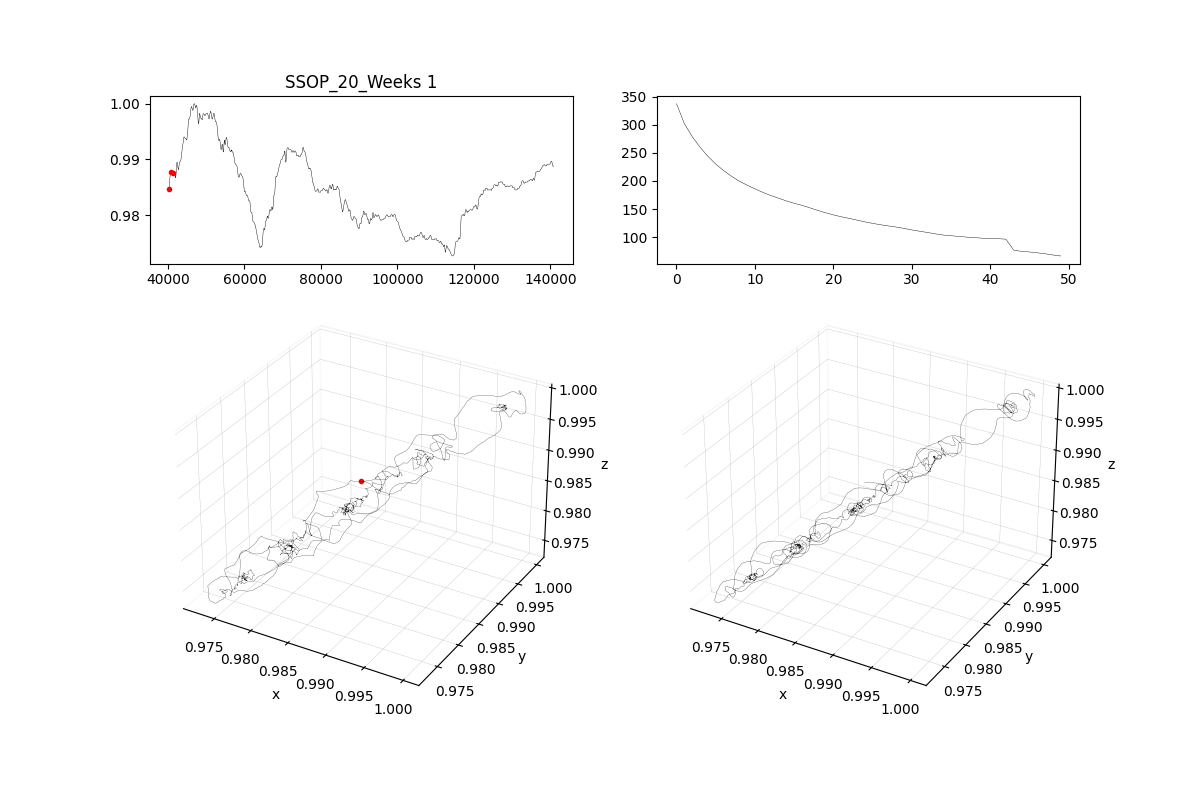

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 209
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.27319656792271796
Correlation Dim : 2.2025655383844023
Lyapunov exponent  : -0.0013561487852872054
False Neightbor (Dim): 8
DMI 5.0
ADFD 33.0


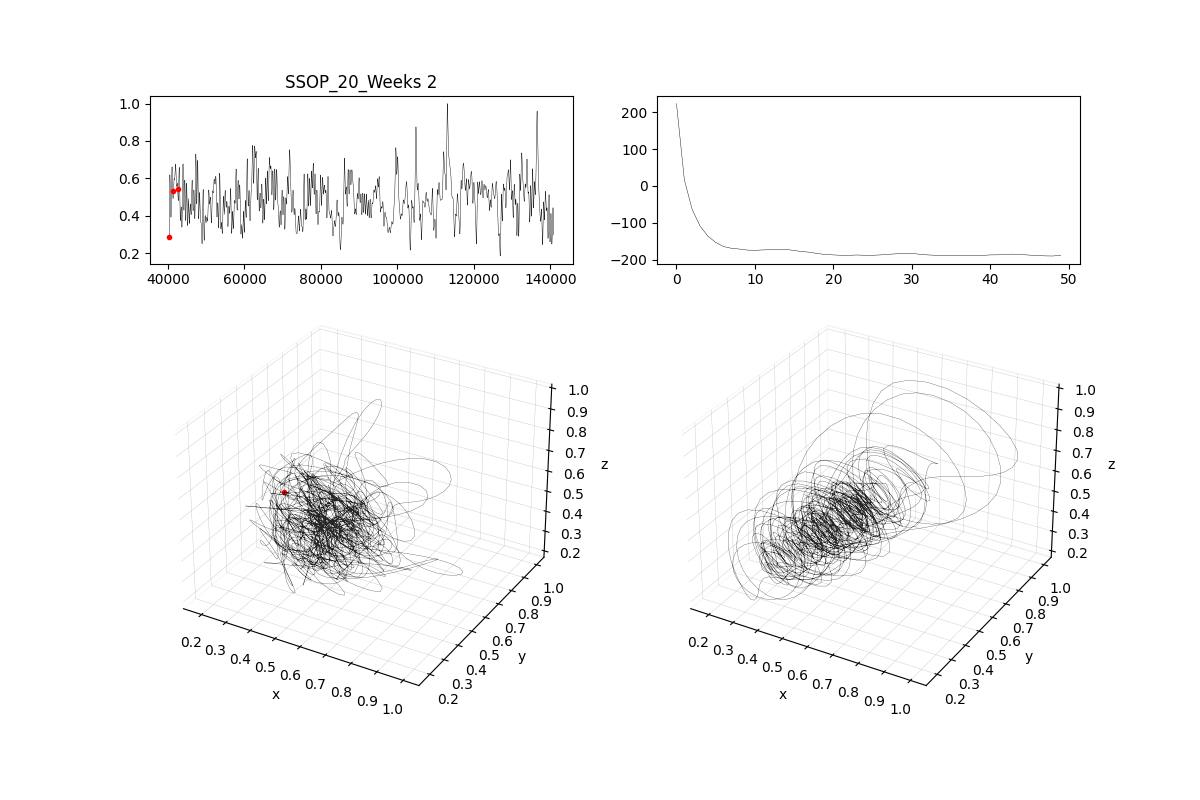

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 244
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.23576610784957144
Correlation Dim : 2.415492507753315
Lyapunov exponent  : 0.020992934488258605
False Neightbor (Dim): 7
DMI 5.0
ADFD 28.0


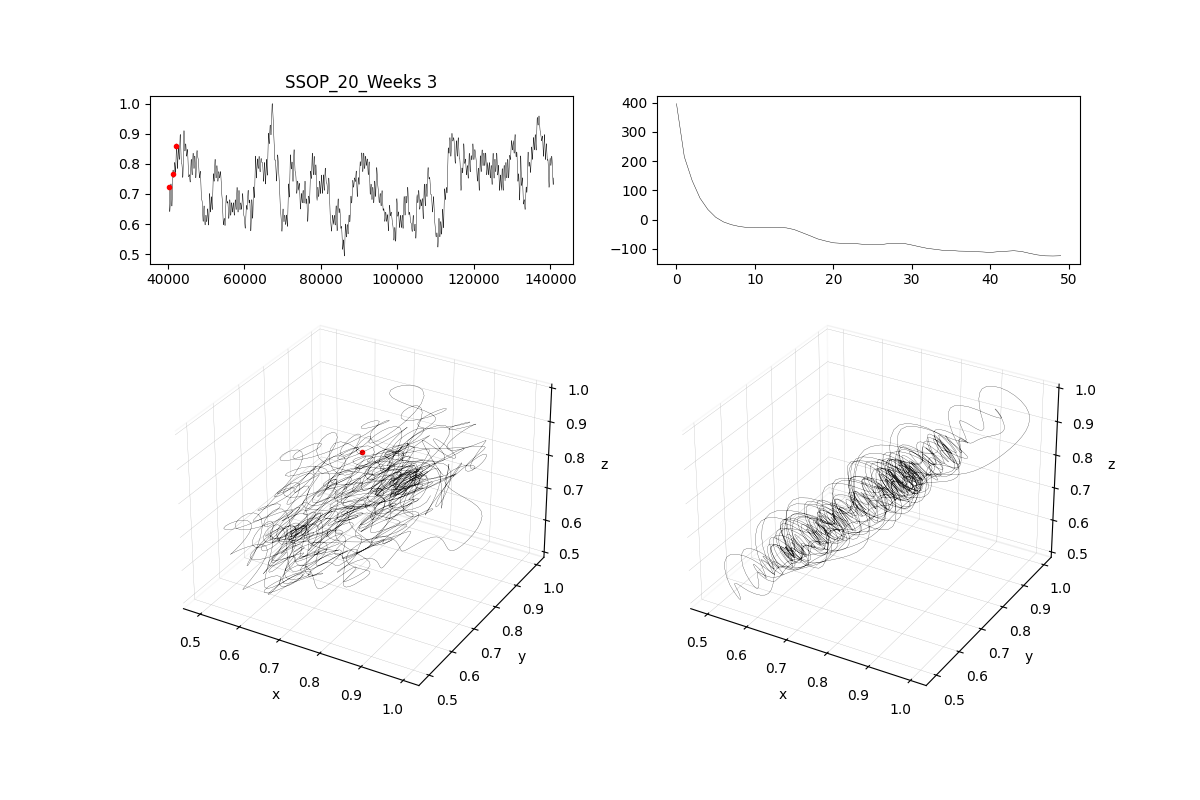

C:\Users\marti\AppData\Local\Temp\ipykernel_27836\3601497234.py:1097: RuntimeWarning: invalid value encountered in multiply
  H = -(P * np.log2(P)).sum()
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 244
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.29262890014677645
Correlation Dim : 2.5253344855025337
Lyapunov exponent  : 0.001801257783716406
False Neightbor (Dim): 7
DMI 5.0
ADFD 6.0


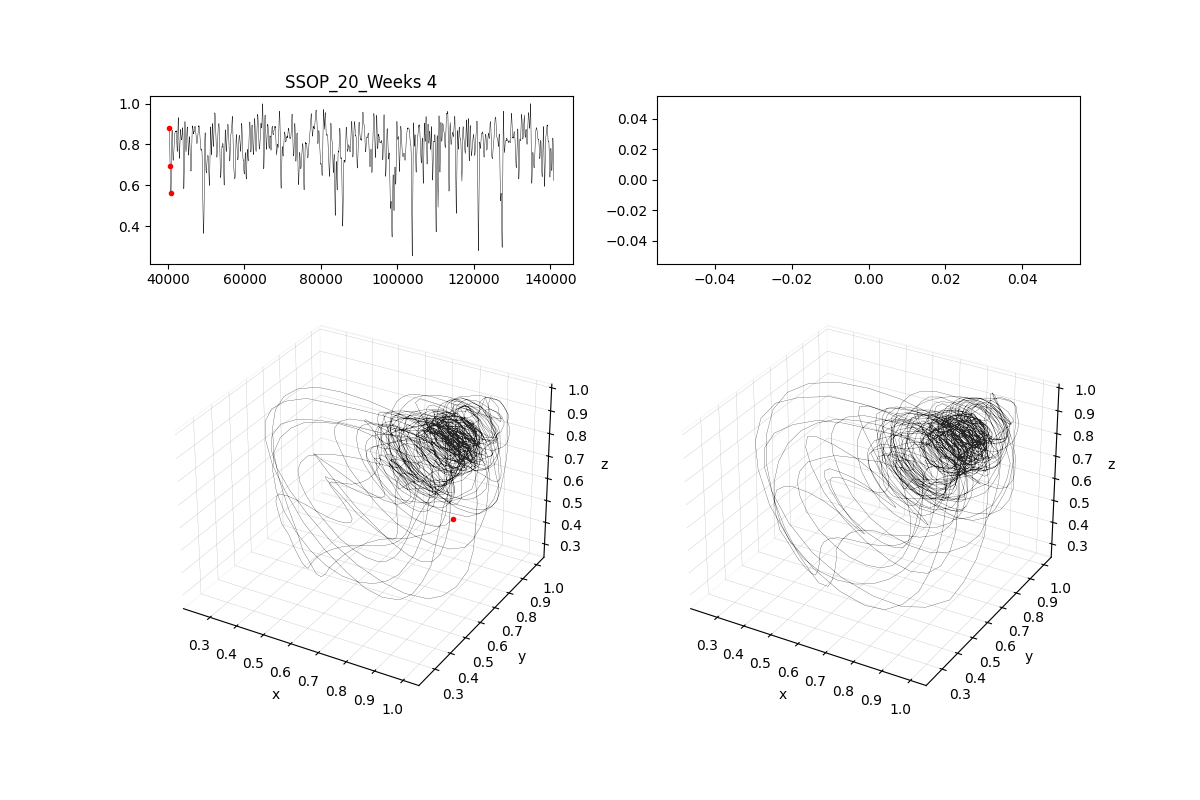

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 209
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.2716433520221147
Correlation Dim : 2.267343643048469
Lyapunov exponent  : 0.010104650259017967
False Neightbor (Dim): 8
DMI 5.0
ADFD 25.0


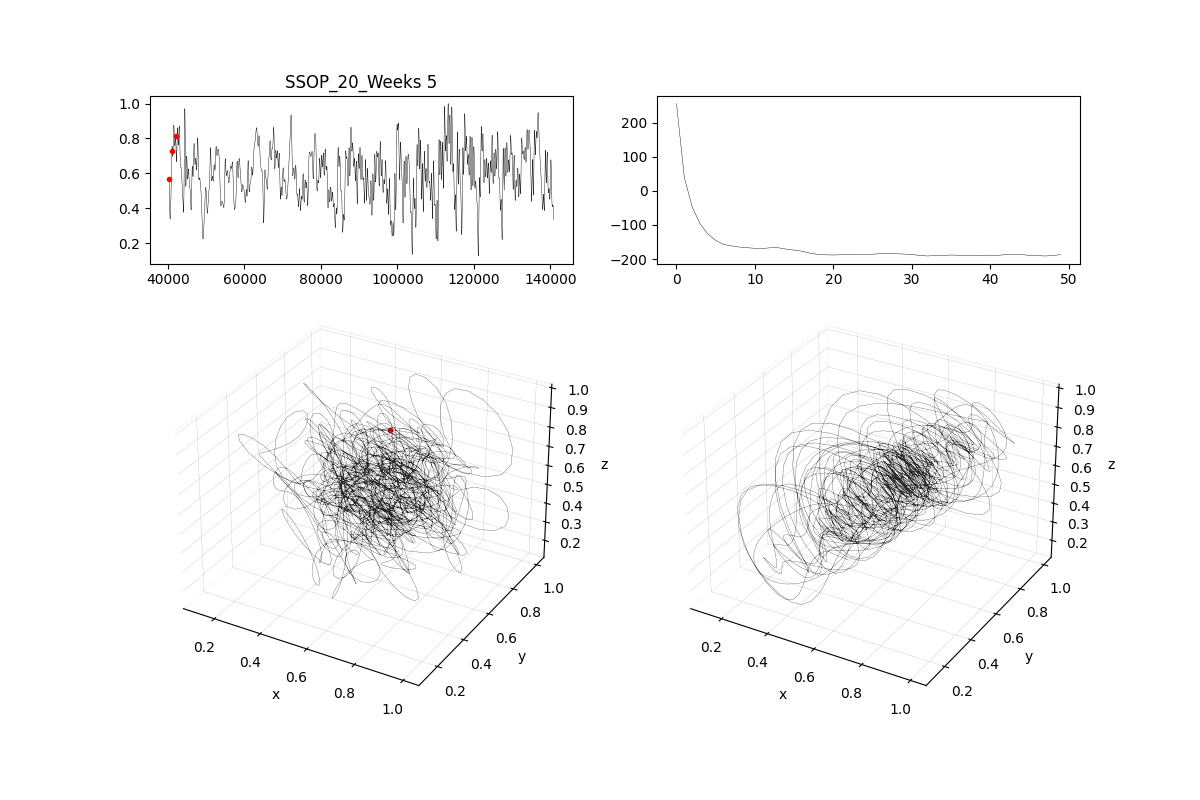

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 487
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.09151569449902497
Correlation Dim : 0.9942672817011721
Lyapunov exponent  : 0.005057660439856891
False Neightbor (Dim): 4
DMI 6.0
ADFD 34.0


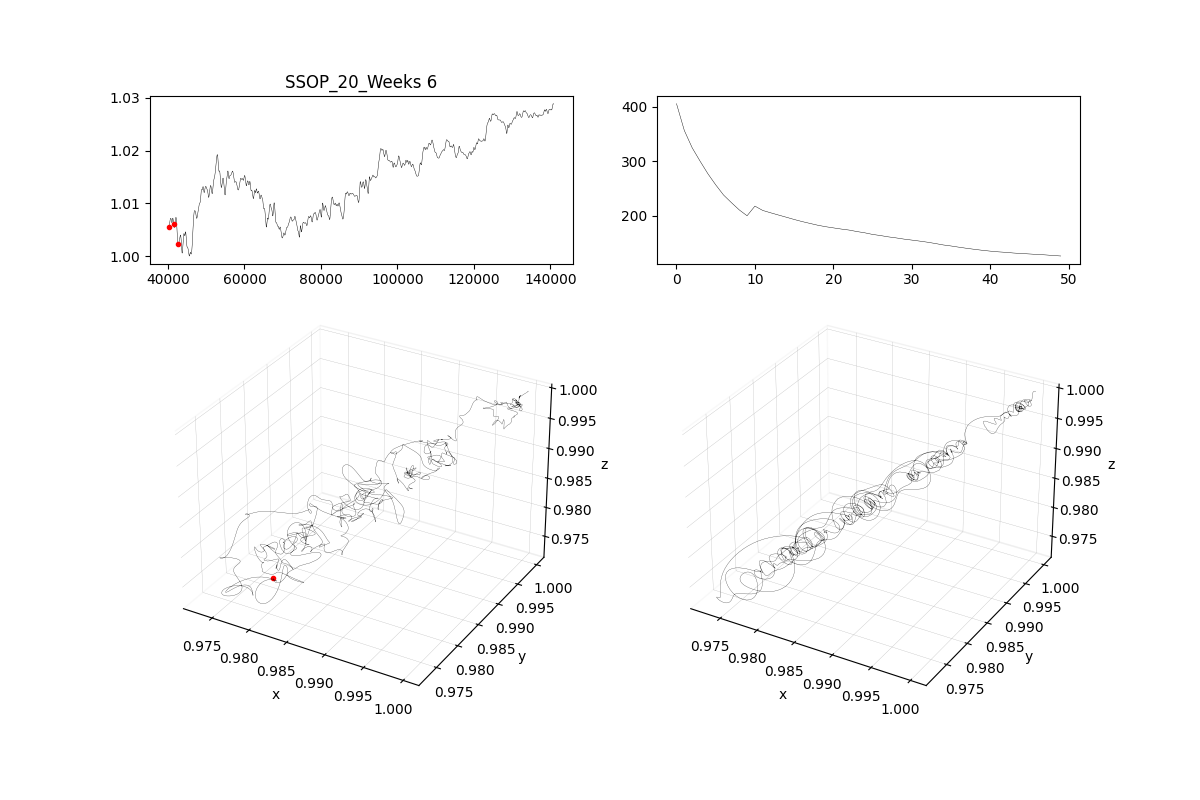

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 750
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\nolds\measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 209
  warnings.warn(msg.format(lag), RuntimeWarning)


K2En 0.2716771440021804
Correlation Dim : 2.2672306657529937
Lyapunov exponent  : 0.01015012242964336
False Neightbor (Dim): 8
DMI 5.0
ADFD 32.0


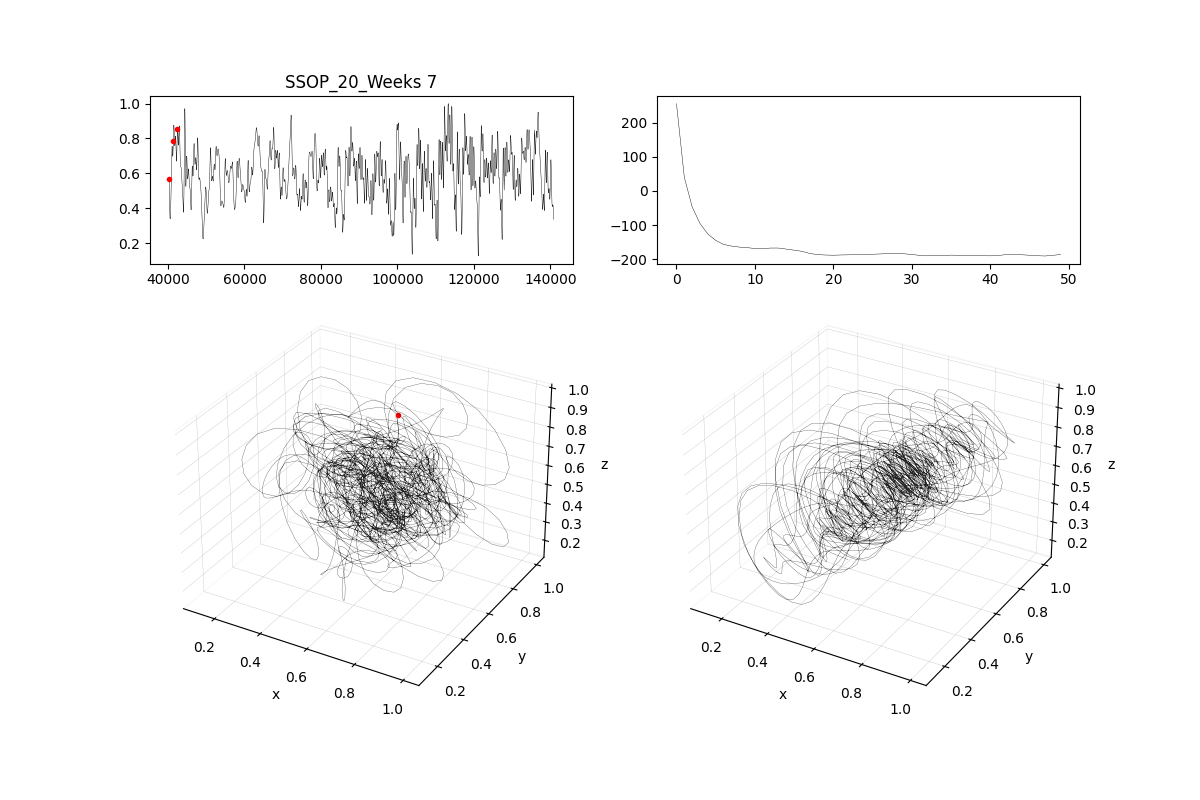

In [13]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
from nolitsa import delay, noise
import EntropyHub as EH
import nolds as nolds

# Data
# filename = "Idle_1day_orderDelay"
# filename ="aggregat_ssop"
filename = "SSOP_20_Weeks"
# filename = "Q_20_Weeks"


nMax = 8 # data colum 
# Define embedding parameters
embedding_dim = 3
interpolate = True
# 42 = 1 woche
# 252 = 6 Wochen
fromWeeks = 1 * 42 * 4
toWeeks = 42 * 10


filedata = np.loadtxt("data/" + filename + ".txt", skiprows=fromWeeks)
time = [x[0] for x in filedata]
time = time[:toWeeks]

for n in range(1,nMax,1):
    values = [x[n] for x in filedata]
    values = values[:toWeeks]
    # create a figure
    fig = plt.figure()
    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(8)
    # set width of each subplot as 8
    fig.set_figwidth(12) 
    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=2,
                            width_ratios=[1,1], wspace=0.2,
                            hspace=0.1, height_ratios=[1,2.5])

    axl = fig.add_subplot(spec[0])
    ax0l = fig.add_subplot(spec[1])
    axr = fig.add_subplot(spec[2], projection='3d', adjustable='box')
    axr2 = fig.add_subplot(spec[3], projection='3d', adjustable='box')

    set_plotsetting(axr)
    set_plotsetting(axr2)
    # Setting the axes properties
    axl.set_title(filename + " " + str(n))
   
    if(interpolate):
        # Define a new set of time points for interpolation
        new_time = np.linspace(min(time), max(time), num=3000, endpoint=False)
        # Create a non-linear interpolation function using a cubic spline
        interp_func = interp1d(time, values, kind='cubic') #-- , fill_value='extrapolate')
        # Use the interpolation function to estimate new values
        x = interp_func(new_time)
    else:
        new_time = np.array(time)
        x = np.array(values)

    
    x = noise.nored(x, dim=embedding_dim, tau=embedding_delay, r=0.2, repeat=5)
    x = x / x.max(axis=0)


    # Create embedding matrix
    miinf, lags = mi(x) 
    ax0l.plot(lags, miinf, "k", lw=0.3)
    # calculate embedding delay 
    fnn_data = fnn(x, 30)
    adfd = delay.adfd(np.array(values), dim=fnn_data, maxtau=100)
    dmi = delay.dmi(np.array(values))
   
    
    
    # calculate Attractor specs
    cor_dim = nolds.corr_dim(x, fnn_data)
    lap = nolds.lyap_r(x, min_tsep=None, emb_dim=fnn_data)
    
    adfd = np.array(adfd[adfd != 0])

    embedding_delay = int(np.max([np.round(dmi.max()), np.round(adfd.mean()),fnn_data]))
    K2, Ci = EH.K2En(np.array(x), m=3, tau=fnn_data) 
    print("K2En " + str(K2[0:1][0])) 
    print("Correlation Dim : " +  str(cor_dim))
    print("Lyapunov exponent  : " +  str(lap))
    print("False Neightbor (Dim): " +  str(fnn_data))
    print("DMI " +  str(np.round(dmi.max())))
    print("ADFD " +  str(np.round(adfd.mean())))
    # print("Delay (applied): " + str(embedding_delay))

    
    data = delay_embedding(x, embedding_dim, lag=int(np.round(adfd.mean())))
    data = data / data.max(axis=0)
    data = data.transpose()
    #fractal_dim = fractal_dimension(dataT, n_samples=1000)
    data2 = delay_embedding(x, embedding_dim, lag=int(np.round(dmi.max())))
    data2 = data2 / data2.max(axis=0)
    data2 = data2.transpose()

    # left plot
    
    axl.plot(new_time, x, "k", lw=0.3)
    point, = axl.plot(new_time[0], x[0], "o", markersize=3, color='red')
    point2, = axl.plot(new_time[embedding_delay], x[embedding_delay], "o", markersize=3, color='red')
    point3, = axl.plot(new_time[embedding_delay*2], x[embedding_delay*2], "o", markersize=3, color='red')
    point4, = axr.plot(data[0,0], data[1,0], data[2,0], "o", markersize=3, color='red')
    #axr.plot(data[0,0], data[1,0], data[2,0], "l", lw=0.3)
    #point2, = axr.plot(data[0,0], data[1,0], data[2,0], "o", markersize=3, color='red')

    def update(num, data, line):
        point.set_data([new_time[num]], [x[num]])
        point2.set_data([new_time[num+embedding_delay]], [x[num+embedding_delay]])
        point3.set_data([new_time[num+embedding_delay*2]], [x[num+embedding_delay*2]])
        point4.set_data([data[0,num]], [data[1,num]])
        point4.set_3d_properties(data[2, num], 'z')
        line.set_data(data[:2, :num])
        line.set_3d_properties(data[2, :num])
        return point, line, point2, point3# , point4
        
    # ax.plot(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], linewidth=0.3, alpha=0.85, color="black" ) #,linestyle="-.")
    # line, = axr.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1], linewidth=0.3, alpha=0.85, color="black")
    # ani = animation.FuncAnimation(fig, update, 980, interval=20, blit=False, repeat=False, fargs=(data, line))
    #ani.save(filename + '.gif', writer='imagemagick')
    # fig.tight_layout()
    axr.plot(xs=data[0], ys=data[1], zs=data[2], linewidth=0.2, alpha=0.85, color="black")
    axr2.plot(xs=data2[0], ys=data2[1], zs=data2[2], linewidth=0.2, alpha=0.85, color="black")
    #np.savetxt(str(n)+".txt", x, fmt='%s')
    plt.show()

NameError: name 'values' is not defined

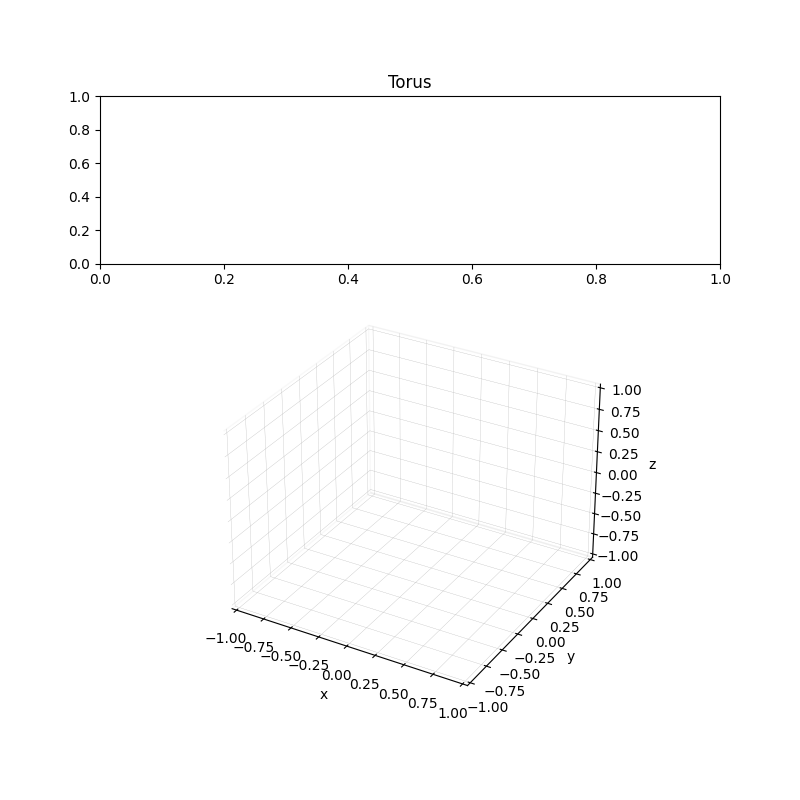

In [1]:
%matplotlib widget

# Synthetic Torus Attractor

from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib.gridspec as gridspec
from sklearn.manifold import SpectralEmbedding
import EntropyHub as EH
from nolitsa import delay


animated = False
spectral = True # False does Standard Embedding

# Define spectral settings
n_components = 3
n_neighbors = 20
t_affinity = "nearest_neighbors"

# Define embedding settings
factor = 1
embedding_dim = 3            # Embedding dimension
embedding_delay = 7 * factor # Time delay

### Begin settings for output.
# create a figure
fig = plt.figure()

# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(8)
# set width of each subplot as 8
fig.set_figwidth(8) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=0.0,
                         hspace=0.1, height_ratios=[1,2.5])

axl = fig.add_subplot(spec[0])
axr = fig.add_subplot(spec[1], projection='3d', adjustable='box')

# Setting the axes properties
axr.xaxis.pane.fill = False
axr.yaxis.pane.fill = False
axr.zaxis.pane.fill = False
axr.xaxis._axinfo["grid"].update({"linewidth":0.2})
axr.yaxis._axinfo["grid"].update({"linewidth":0.2})
axr.zaxis._axinfo["grid"].update({"linewidth":0.2})
axr.grid(which='major', color='#EBEBEB', linewidth=0.01)
axr.set_xlabel('x')
axr.set_ylabel('y')
axr.set_zlabel('z')
axr.set_xlim3d([-1.0, 1.0])
axr.set_ylim3d([-1.0, 1.0])
axr.set_zlim3d([-1.0, 1.0])
# data
filename = "Torus"
axl.set_title(filename)

time = np.linspace(0,500,num=4800*factor)
forward = np.array([x for x in range(15,95)])
backward = np.flip(forward)
full = np.append(backward,forward)
for x in range(1,30*factor):
    full = np.append(full, backward)
    full = np.append(full, forward)

full = full / full.max(axis=0)

#x = np.linspace(0,4000,1)
x = np.sin(time)
x = np.array(full * x)
disp = delay.adfd(np.array(values), dim=embedding_dim, maxtau=100)
disp2 = delay.dmi(np.array(values))
embedding_delay = int(np.round(disp.mean())) # Time delay)
print("Delay ADFD: " + str(embedding_delay) + " DMI " + str(np.round(disp.max())))

if(spectral):  # Create Spectral Attractor
    t_total = np.column_stack((time,x))
    # Fit the attractor
    t_se = SpectralEmbedding(n_components=n_components, affinity= t_affinity, n_neighbors=n_neighbors, n_jobs=-1)
    t_se_data = t_se.fit_transform(X=t_total)
    data = t_se_data * 1000
    data = data / data.max(axis=0)
    data = data.transpose()
else: # Create embedding matrix
    embeddings = np.empty((len(x)-(embedding_dim-1)*embedding_delay, embedding_dim))
    for i in range(embedding_dim):
        embeddings[:, i] = x[i*embedding_delay:i*embedding_delay+len(embeddings)]

    #embeddings = embeddings / embeddings.max(axis=0)
    data = embeddings.transpose()

K2, Ci = EH.K2En(np.array(x, dtype=np.single), m=3, tau=embedding_delay) 
axl.set_title(filename + "  Kolmogorov entropy " + str(K2[0:1][0]))
# left plot
# x = x / x.max(axis=0)
axl.plot(time, x, "k", lw=0.3)
if(animated):
    point, = axl.plot(time[0], x[0], "o", markersize=3, color='red')
    point2, = axl.plot(time[embedding_delay], x[embedding_delay], "o", markersize=3, color='red')
    point3, = axl.plot(time[embedding_delay*2], x[embedding_delay*2], "o", markersize=3, color='red')
    point4, = axr.plot(data[0,0], data[1,0], data[2,0], "o", markersize=3, color='red')
# axr.plot(data[0,0], data[1,0], data[2,0], "l", lw=0.3)
# point2, = axr.plot(data[0,0], data[1,0], data[2,0], "o", markersize=3, color='red')

def update(num, data, line):
    point.set_data([time[num]], [x[num]])
    point2.set_data([time[num+embedding_delay]], [x[num+embedding_delay]])
    point3.set_data([time[num+embedding_delay*2]], [x[num+embedding_delay*2]])
    point4.set_data([data[0,num]], [data[1,num]])
    point4.set_3d_properties(data[2, num], 'z')
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    return point, line, point2, point3# , point4
    
if(animated):
    line, = axr.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1], linewidth=0.3, alpha=0.85, color="black")
    axr.view_init(15, -65)
    ani = animation.FuncAnimation(fig, update, data[0].size-embedding_delay*2, interval=20, blit=False, repeat=False, fargs=(data, line))
else:
    # axr.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1], linewidth=0.3, alpha=0.85, color="black")
    axr.plot(xs=data[0], ys=data[1], zs=data[2], linewidth=0.2, alpha=0.85, color="black")

# ani.save('Torus' + '.gif', writer='imagemagick')
# fig.tight_layout()
plt.show()

In [ ]:
#test data
box = np.zeros(shape = (100,100,100))
box[20:80,20:80,20:80] = 1

fd = fractal_dimension(box, n_offsets=10, plot = True)
print(f"Fractal Dimension of the box: {fd}")
